# New Topic Tool AB Test Report: Logged-In User Analysis

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** 13 April 2022**

[TASK](https://phabricator.wikimedia.org/T277825) | [CODEBASE](https://github.com/wikimedia-research/New-discussion-tool-analysis-2020)

# Table of Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [New Topic Tool Completion Rate](#New-Topic-Tool-Completion-Rate)
4. [Guardrail Analyses](#Guardrail-Analyses)
5. [Curiosities](#Curiosities)


# Introduction

The Wikimedia Foundation's [Editing team](https://www.mediawiki.org/wiki/Editing_team#:~:text=The%20Editing%20team%20is%20the,tools%20like%20TemplateData%20and%20Citoid.) is working to improve how contributors communicate on Wikipedia using talk pages through a series of incremental improvements that will be released over time.

As part of this effort, the Editing team introduced a new workflow for starting new topic threads on talk pages, across Wikipedia's 16 talk namespaces. This new workflow is intended to make it more intuitive for Junior Contributors to initiate conversations in ways other contributors can easily reply to and to help Senior Contributors do the same, with less effort. 


The new topic tool tool provides an an inline form for adding new topics. In addition, the language throughout the workflow was adjusted to be more topic-specific.

The team ran an AB test of the New Topic Tool from 27 January 2022 through 25 March 2022 [^timeline] to assess the efficacy of this new feature. The test included all logged-in and logged-out users that edited a talk page at one the 20 participating Wikipedias  during the duration of the AB test (see full list of [participating Wikipedias in task description](https://phabricator.wikimedia.org/T277825) and conditions outlined in the methodology section below). During this test, 50% of users included in the test had the New Topic tool automatically enabled, and 50% did not. This report focues on the results for logged-in users. 

[^timeline]: Note that we excluded logged-out data collected from from 27 January 2022 to 17 February 2022 in this analysis due to errors in the bucketing implementation that did not accurately log all the events in the AB test.

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/wiki/Talk_pages_project/New_discussion).

# Methodology

The AB test was run on a per Wikipedia basis and contributors included in the test were randomly assigned to either the control (new topic tool disabled by default) or treatment (new topic tool enabled by default). We excluded logged-in users that have previously used the New Topic tool (as determined by the state of the `discussiontools-newtopictool-opened` preference) but included users users that had explicitly enabled or disabled the overall Discussion tools beta feature. Users at these Wikipedias were still able to turn the tool on or off the tool in Special:Preferences; however, they remained in the same group they were buketed in for the duration of the test. 

Upon conclusion of the test on 25 March 2022, we recorded a total of 24,197 new topic attempts initiated across both test groups by 7,394 distinct contributors across all experience levels. A total of 4,361 (59%) of these contributors were identified as Junior Contributors. Data was collected in [EditAttemptStep](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/editattemptstep/) and [talk_page_edit](https://schema.wikimedia.org/repositories//secondary/jsonschema/analytics/mediawiki/talk_page_edit/current.yaml) .

In this test, a user can add a new topic using the New Topic Tool or using the existing add new section link interface. For the purpose of this analysis, these two types of editing experiences are defined as follows: 

**New Topic Tool:** Any edit to add a new topic (section) to a talk page namespace made with the new topic tool. The new topic tool allows edits using both wikitext and source mode. New Topic tool events were sampled at 100%. 

Recorded in EditAttemptStep as: `event.action = 'init'`, `event.integration = 'discussiontools'`, `event.init_type = 'section'`


**Existing Add New Section Link:** Any edit to add a new topic (section) using the existing `section=new` link and workflow. These events were sampled at a rate of 1/16, or 6.125%.  

Recorded in the EditAttemptStep as: `event.action = 'init', event.integration = 'page' , event.init_type = 'section', event.init_mechanism IN ('url-new', 'new')` 

We excluded the following types of edits from this analysis: (1) edits made with the reply tool, (2) full-page edits to create a new page or to an existing page, (3) corrective edits to an existing section. Note: It's possible to create a new section using full page editing but these were excluded for the following reasons: (1) we do not have instrumentation to decipher beween an attempt to make an edit to existing text on the page vs an edit attempt to create a new section using full page editing; and (2) this method exists in both the test and control groups and we do not believe would be impacted by the appearance of the new topic tool.  

See the following Phabricator tickets for further details regarding instrumentation and implementation of the AB test:

* Implement AB test bucketing [T291307](https://phabricator.wikimedia.org/T291307)
* Start AB test [T291308](https://phabricator.wikimedia.org/T291308)


In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
   # Modeling 
    library(brms)
    library(lme4)
    library(tidybayes)
    set.seed(5)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [20]:
options(repr.plot.width = 15, repr.plot.height = 10)

In [85]:
# collect all new topic tool attempts and saves
# Add a join with talk_page_edit to ensure all saved edits are included due to bug https://phabricator.wikimedia.org/T305541
query <-
"
--find all edit attempts
WITH edit_attempts AS (
    SELECT
      wiki AS wiki,
      event.user_id as user_id,
      event.editing_session_id as edit_attempt_id,
      event.bucket AS experiment_group,
      event.is_oversample AS is_oversample,
      event.integration AS editing_method,
      If(event.integration == 'discussiontools', 1, 0) AS new_topic_tool_used,
      CASE
           WHEN event.init_type = 'section' AND event.integration == 'discussiontools' THEN 'new_topic_tool'
           WHEN event.init_type = 'section' AND event.integration == 'page' AND event.init_mechanism IN ('url-new', 'new') THEN 'new_section_link'
          ELSE 'NA' -- check to make sure all edit types accounted for in above list
          END AS section_edit_type,
          event.user_editcount AS experience_level
    FROM event.editattemptstep
    WHERE
-- only in participating wikis
    wiki IN ('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki', 'frwiki', 'hewiki', 'hiwiki',
    'idwiki', 'itwiki', 'jawiki', 'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki', 'thwiki',
    'ukwiki', 'viwiki')
-- since deployment
    AND year = 2022
    AND ((month = 01 and day >= 27) OR (month = 02) OR
     (month = 03 and day <= 25))
  -- remove bots
    AND useragent.is_bot = false
-- look at only desktop events
    AND event.platform = 'desktop'
-- review all talk namespaces
    AND event.page_ns % 2 = 1
-- only users in AB test
    AND event.bucket IN ('test', 'control')
-- only registered user
    AND event.user_id != 0
    AND event.action = 'init'
-- discard VE/Wikieditor edits to create new page or reply tool edits
    AND NOT (
 -- not a reply tool edit
  (event.init_type = 'page' AND event.integration = 'discussiontools') OR
 -- not an wikitext edit to create a new page
   (event.init_type = 'page' AND event.init_mechanism IN ('url-new', 'new') AND event.integration = 'page') OR
 -- not a corrective edit to an existing section
   (event.init_type = 'section' AND event.init_mechanism IN ('click', 'url') AND event.integration == 'page') OR
-- not a full page edit
   (event.init_type = 'page' AND event.init_mechanism IN ('click', 'url') AND event.integration = 'page')
 )),

-- find all published comments
published_dt_new_topics AS (
    SELECT
    performer.user_id AS user_id,
    session_id AS edit_save_id,
    `database` AS wiki
    FROM event.mediawiki_talk_page_edit
    WHERE
    year = 2022
   AND ((month = 01 and day >= 27) OR (month = 02) OR
 (month = 03 and day <= 25))
   -- only in participating wikis
    AND `database` IN ('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki', 'frwiki', 'hewiki', 'hiwiki',
    'idwiki', 'itwiki', 'jawiki', 'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki', 'thwiki',
    'ukwiki', 'viwiki')
),

published_section_link_new_topics AS (
SELECT
     event.user_id as user_id,
     event.editing_session_id AS edit_save_id,
     wiki AS wiki
     FROM event.editattemptstep
     WHERE
 -- only in participating wikis
     wiki IN ('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki', 'frwiki', 'hewiki', 'hiwiki',
     'idwiki', 'itwiki', 'jawiki', 'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki', 'thwiki',
     'ukwiki', 'viwiki')
     AND year = 2022
      AND ((month = 01 and day >= 27) OR (month = 02) OR
 (month = 03 and day <= 25))
   AND event.action = 'saveSuccess'
)


-- main query
SELECT
    eas.wiki,
    eas.user_id,
    edit_attempt_id,
    experiment_group,
    is_oversample,
    editing_method,
    new_topic_tool_used,
    section_edit_type,
-- was saved in either talk page edit or editattemptstep
    IF ((section_edit_type = 'new_topic_tool' AND (tpe_save.edit_save_id IS NOT NULL OR eas_save.edit_save_id IS NOT NULL))
        OR (section_edit_type = 'new_section_link' AND (tpe_save.edit_save_id IS NOT NULL OR eas_save.edit_save_id IS NOT NULL)), 1, 0) AS edit_success,
     experience_level
FROM edit_attempts eas
LEFT JOIN published_dt_new_topics tpe_save ON
    eas.edit_attempt_id = tpe_save.edit_save_id AND
    eas.wiki = tpe_save.wiki
LEFT JOIN published_section_link_new_topics eas_save ON
    eas.edit_attempt_id = eas_save.edit_save_id AND
    eas.wiki = eas_save.wiki
"


In [86]:
new_topic_attempts <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [88]:
# data reformatting and cleanup

#set factor levels with correct baselines
new_topic_attempts$section_edit_type <-
  factor(
    new_topic_attempts$section_edit_type,
    levels = c("NA", "full_page_edits", "new_section_link", "new_topic_tool"),
    labels = c("NA", "Full page edits", "Existing add new section link", "New topic tool")
  )

new_topic_attempts$edit_success <-
  factor(
    new_topic_attempts$edit_success,
    levels = c(0, 1),
    labels = c("Not Complete", "Complete")
  )


# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
new_topic_attempts$user_id <-
  as.character(paste(new_topic_attempts$user_id, new_topic_attempts$wiki, sep ="-"))

#clarfiy wiki names
new_topic_attempts <- new_topic_attempts %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'amwiki' ~ "Amharic Wikipedia",
      wiki == 'bnwiki' ~ "Bengali Wikipedia",
      wiki == 'zhwiki' ~ "Chinese Wikipedia",
      wiki == 'nlwiki' ~ 'Dutch Wikipedia',
      wiki == 'arzwiki' ~ 'Egyptian Wikipedia',
      wiki == 'frwiki' ~ 'French Wikipedia',
      wiki == 'hewiki' ~ 'Hebrew Wikipedia',
      wiki == 'hiwiki' ~ 'Hindi Wikipedia',
      wiki == 'idwiki' ~ 'Indonesian Wikipedia',
      wiki == 'itwiki' ~ 'Italian Wikipedia',  
      wiki == 'jawiki' ~ 'Japanese Wikipedia',   
      wiki == 'kowiki' ~ 'Korean Wikipedia',
      wiki == 'omwiki' ~ 'Oromo Wikipedia', 
      wiki == 'fawiki' ~ 'Persian Wikipedia',  
      wiki == 'plwiki' ~ 'Polish Wikipedia',   
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
      wiki == 'eswiki' ~ 'Spanish Wikipedia',
      wiki == 'thwiki' ~ 'Thai Wikipedia',  
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia',
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'    
    )
  ) 

In [89]:
# Create new column to identify Junior and Non-Junior Contributors

new_topic_attempts <- new_topic_attempts %>%
  mutate(
    is_junior = case_when(
      #clarfiy participating project names
      experience_level < 100 ~ "Junior Contributor",
      experience_level >=  100 ~ "Non-Junior Contributor"   
    ),
    is_junior = factor(is_junior,
         levels = c("Non-Junior Contributor", "Junior Contributor")
   ))


## New topic attempts in each group

Since all Discussion Tool events including new topic tool events are oversampled (100% sampling rate) in EditAttemptStep, we removed oversampled events so we can directly compare the balance between each experiment group.

In [90]:
new_topic_attempts_bygroup <- new_topic_attempts %>%
   filter(is_oversample == 'false') %>% #All Discussion Tool events are oversampled - removing to check balance.
  group_by(experiment_group) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id), .groups = 'drop')

new_topic_attempts_bygroup

experiment_group,users,attempts
<chr>,<int>,<int>
control,952,1501
test,943,1675


# New Topic Tool Completion Rate

Our key performance indicator (KPI) for this analysis is new topic completion rate. For the purpose of this analysis, we are defining the completion rate as the percent of contributors that successfully published (`event.action = 'saveSuccess'` in EditAttemptStep)[^instrumentation] at least one comment after clicking the Add topic / New section link interface (`event.action = 'init'`) during the time of the AB test.

Note that this does not take into account the number of attempts it took for the user to publish or the duration of their editing sessions. For comparison purposes, we also reviewed completion rate defined as the percent of all new topic edit attempts by Junior Contributors that were successfully published. This was also the dataset we used to model the impact of the new topic tool as the model accounts for both user and wiki experience on the success of each edit attempt.

[^instrumentation]: During this analysis, we identified a [bug](https://phabricator.wikimedia.org/T305541) where some instances of edits sessions completed using the new topic tool were not correctly recorded as being sucessfully saved in EditAttemptStep. As a result, we also used the talk_page_edit schema to more accurately account for all edits posted by the new topic tool by joining this data with init events identifed in EditAttemptStep. 

## New Topic Tool Completion Rate by Junior Contributors

We first calculated the new topic completion rate for Junior Contributors overall and across each participating Wikipedia. 


### Overall new topic completion rate by Junior Contributors 

#### New topic completion rate defined as percent of edit attempts that are successfully published

In [50]:
# Completion Rate By Session

new_topic_attempts_jc_bysession <- new_topic_attempts %>%
    filter(is_junior == 'Junior Contributor')  %>%  #only jc 
    group_by (wiki, section_edit_type) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_completions = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              #n_completions = sum(edit_success == 'Complete'),
           new_topic_tool_used = as.integer(ifelse(sum(section_edit_type== 'New topic tool'), 1, 0)),
    .groups = 'drop') 


In [51]:
# By session

new_topic_attempts_jc_bysession_all <- new_topic_attempts_jc_bysession %>%
    group_by(section_edit_type) %>%
    summarise(n_attempts = sum(n_attempts), 
              n_attempts_completed = sum(n_completions), 
              completion_rate = paste0(round(n_attempts_completed / n_attempts  *100, 1), "%"),
              .groups = 'drop'
  ) 
new_topic_attempts_jc_bysession_all

section_edit_type,n_attempts,n_attempts_completed,completion_rate
<fct>,<int>,<int>,<chr>
Existing add new section link,511,179,35%
New topic tool,6409,2314,36.1%


#### New topic completion rate defined as percent of Junior Contributors that successfully publish at least 1 new topic

In [132]:
# Completion Rate By Junior Contributors
new_topic_attempts_jc <- new_topic_attempts %>%
    filter(is_junior == 'Junior Contributor')  %>%  #only jc 
    group_by (wiki, section_edit_type, user_id) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_completions = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              edit_success = ifelse(sum(n_completions >= 1), 'Complete', 'Not Complete'),  #redefine edit success as user completed at least 1 edit attempt
           new_topic_tool_used = as.integer(ifelse(sum(section_edit_type== 'New topic tool'), 1, 0)),
    .groups = 'drop') 


In [133]:
# By Contributor
# Review edit completion rate by editing method
new_topic_attempts_jc_all <- new_topic_attempts_jc %>%
    group_by(section_edit_type) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(n_completions >= 1), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) 

In [134]:
# Create table of completion rate
new_topic_attempts_jc_all_table <- new_topic_attempts_jc_all %>%
  gt() %>%
  tab_header(
    title = "Junior contributors new topic completion rate",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    section_edit_type = "Editing method",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "New topic completion rate"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that attempted and published at least 1 new topic",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "Sampling rate for Non-New Topic Tool events is 6.25%",
    locations = cells_body(
      columns = 'section_edit_type', rows = 1)
    ) %>%
  tab_footnote(
    footnote = "Sampling rate for New Topic Tool events is 100%",
    locations = cells_body(
      columns = 'section_edit_type', rows = 2)) %>%
    gtsave(
    "new_topic_attempts_jc_all_table.html", inline_css = TRUE)

IRdisplay::display_html(data = new_topic_attempts_jc_all_table, file = "new_topic_attempts_jc_all_table.html")

1 Defined as percent of contributors that attempted and published at least 1 new topic 2 Sampling rate for Non-New Topic Tool events is 6.25% 3 Sampling rate for New Topic Tool events is 100%


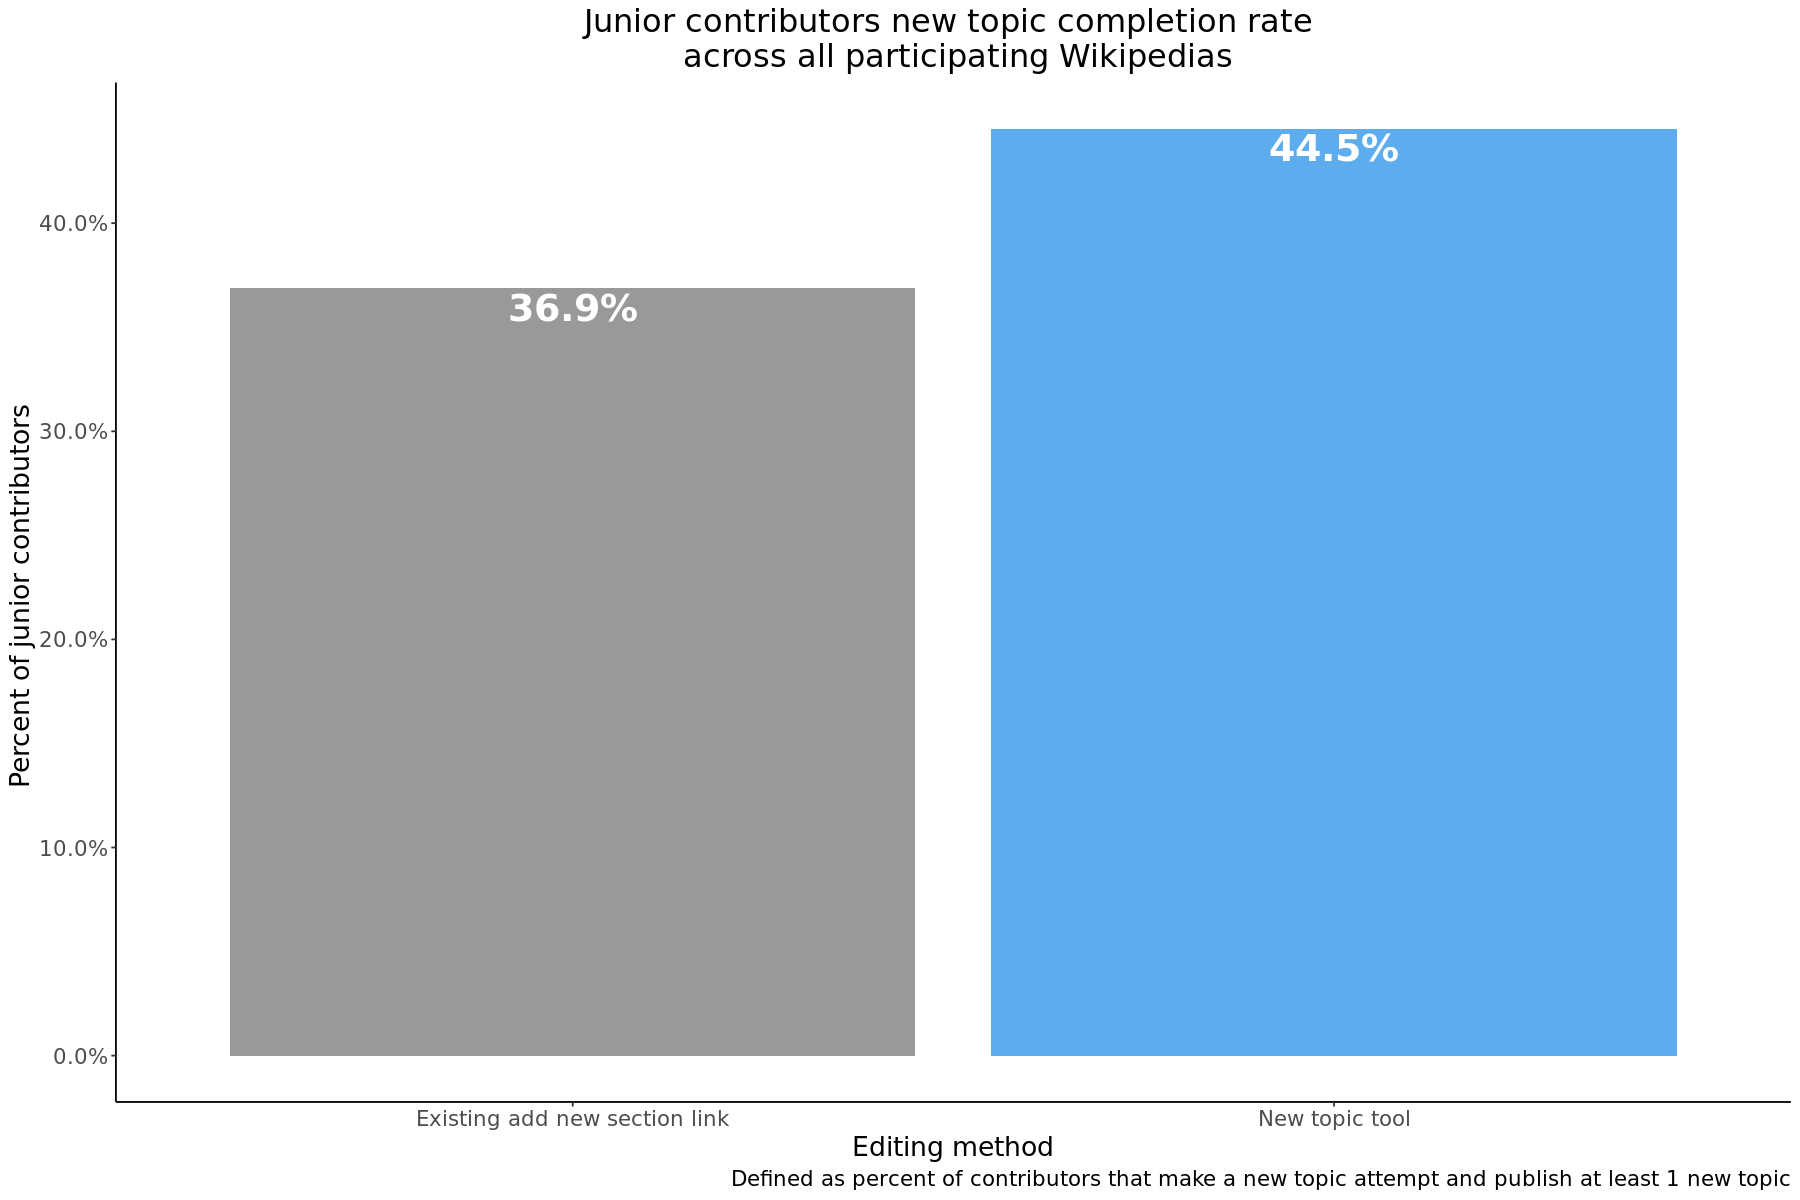

In [135]:

p <- new_topic_attempts_jc_all  %>%
    ggplot(aes(x= section_edit_type, y = n_users_completed / n_users, fill = section_edit_type)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Existing add new section link", "New topic tool")) +
    labs (y = "Percent of junior contributors ",
          x = "Editing method",
          title = "Junior contributors new topic completion rate \n across all participating Wikipedias",
         caption = "Defined as percent of contributors that make a new topic attempt and publish at least 1 new topic")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/new_topic_attempts_jc_all.png", p, width = 16, height = 8, units = "in", dpi = 300)


Overall, 44.5% of all Junior Contributors that made a new topic attempt were able to successfully publish at least 1 new topic with the new topic tool, while 36.9% of all Junior Contributors successfully published a new topic using the previous new section link editing workflow. This represents a 7 percentage point (36.9% → 44.5%); 20% observed increase in new topic completion rate. 

Note that this does not take into account the number of attempts it took for the user to publish or the duration of their editing sessions. If we look just at the percent of editing sessions succesfully completed, there was a 1.1 percentage point (35% → 36.1%); 3% observed increase in new topic completion rate for editing sessions completed using the new topic tool. 

### New topic completion rate by participating Wikipedia 

In [27]:
# Review edit attempts by editing method and wiki
new_topic_attempts_jc_bywiki <- new_topic_attempts_jc %>%
    group_by(wiki, section_edit_type) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(n_completions >=1), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%")) %>%
    ungroup()  %>%  #determine credible intervals
    cbind(as.data.frame(binom:::binom.bayes(x = .$n_users_completed, n = .$n_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))
        


`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



In [31]:
new_topic_attempts_jc_bywiki_tbl <- new_topic_attempts_jc_bywiki   %>%
  select(c(1,2,3,4,5,12,13))  %>% #remove unneeded rows
  gt() %>%
  tab_header(
    title = "Junior contributors new topic completion rate by participating Wikipedia"
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    section_edit_type= "Editing method",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Completion rate",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that make a new topic attempt and publish at least 1 new topic",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "Sampling rate for Non-New Topic Tool events is 6.25%",
     locations = cells_column_labels(
      columns = 'section_edit_type'
    ) 
    ) %>%
  tab_footnote(
    footnote = "Sampling rate for New Topic Tool events is 100%",
    locations = cells_column_labels(
      columns = 'section_edit_type'
    )) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )) %>%
    gtsave(
    "new_topic_attempts_jc_bywiki_tbl .html", inline_css = TRUE)

IRdisplay::display_html(data = new_topic_attempts_jc_bywiki_tbl, file = "new_topic_attempts_jc_bywiki_tbl .html")

new_topic_attempts_jc_bywiki_tbl 

1 Sampling rate for Non-New Topic Tool events is 6.25% 2 Sampling rate for New Topic Tool events is 100% 3 Defined as percent of contributors that make a new topic attempt and publish at least 1 new topic 4 95% credible intervals. There is a 95% probability that the parameter lies in this interval


NULL

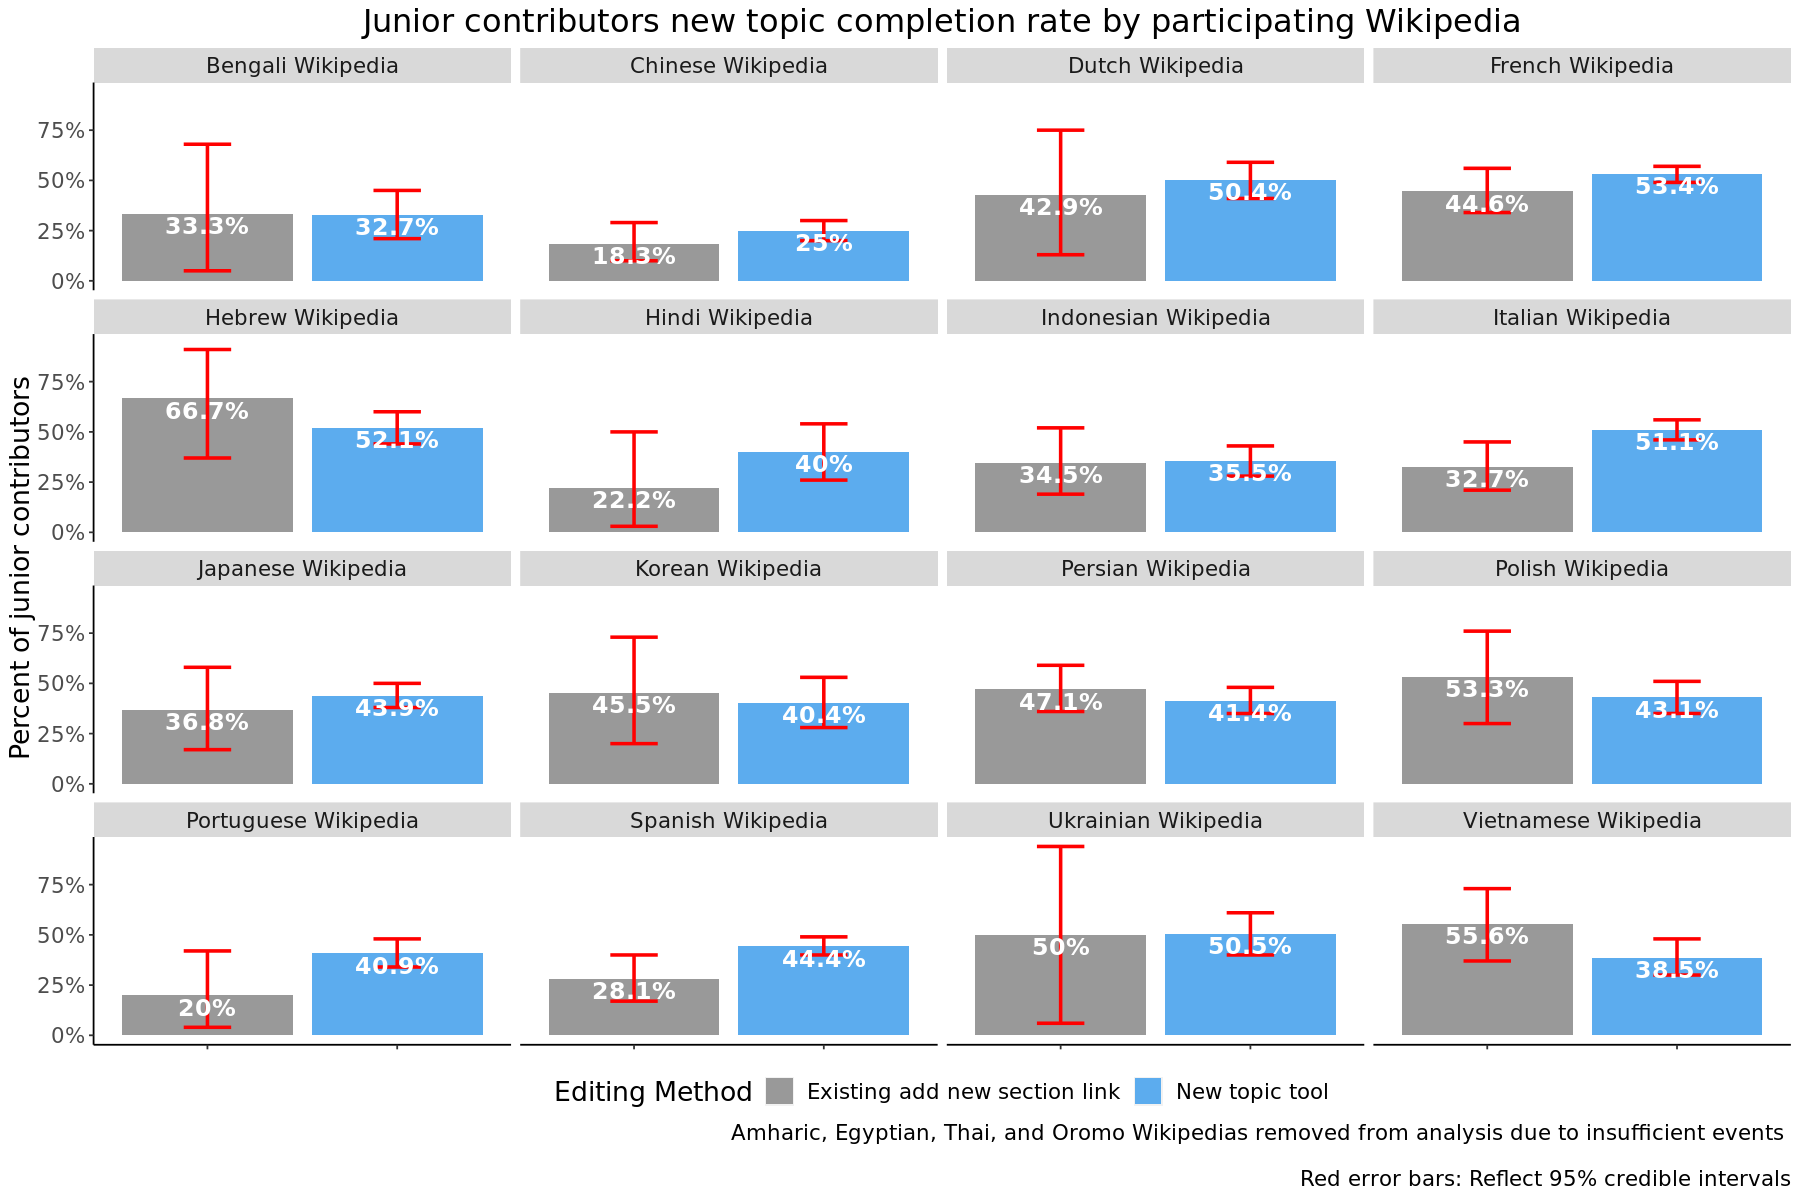

In [34]:
# Plot edit completion rates for each wiki  

dodge <- position_dodge(width=0.9)

p <- new_topic_attempts_jc_bywiki  %>%
    filter(!(wiki %in% c('Amharic Wikipedia', 'Egyptian Wikipedia', 'Thai Wikipedia'))) %>% # remove wikis where there are under 10 events as we 
    ggplot(aes(x= section_edit_type, y = n_users_completed / n_users, fill = section_edit_type)) +
    geom_col(position = 'dodge') +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, position = dodge, width = 0.25) +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of junior contributors ",
          title = "Junior contributors new topic completion rate by participating Wikipedia",
         caption = "Amharic, Egyptian, Thai, and Oromo Wikipedias removed from analysis due to insufficient events \n
         Red error bars: Reflect 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Editing Method", labels = c("Existing add new section link", "New topic tool"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/new_topic_attempts_jc_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

Trends vary on a per wikipedia basis.  

While the majority of participating Wikipedia saw a higher new topic completion rate with the new topic tool, 6 of the participating Wikipedias (Hebrew, Korean, Persian, Polish, Ukranian, Vietnamese) saw a slightly higher new topic completion rates with the previous new section link editing workflow. There were no signficiant differences between the two editing methods for any particular wiki.

Some of this variation may be caused by the smaller sample sizes available for review on a per Wikipedia basis, especially for the previous add new section link events which were sampled at only 6.25%. These smaller sample sizes resulted in greater credible intervals and, therefore, higher uncertainty in the identified percentages (as represented by larger red error bars on the chart above). 

Running the AB test for longer or increasing the sampling rate for non new topic tool events would help confirm any of these differences. 


### Modeling the impact of the new topic tool

We next explored different models to correctly infer the impact of the new topic tool on whether a new topic was completed or not and account for the random effects by the user and wiki. This allows us to confirm if the observed increase above is statistically significant (did not occur due to random chance).

New topic attempts completed on the same Wikipedia and by the users on that Wikipedia are related to each other. Therefore, we can more accurately infer the impact of the new topic tool by accounting for the effect of the user and wiki on the success probability of a Junior Contributor completing an edit.

We used a [Bayesian Hierarchical regression model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling) to model this structure. For this model, we reviewed whether each edit attempt was sucesfully completed or not. We identified the user and Wikipedia as random effects and whether the new topic tool was used as the fixed effect or predictor variable.

In [35]:
#redefine edit success as factor for use in the model
new_topic_attempts_jc$edit_success <-
  factor(
    new_topic_attempts_jc$edit_success,
    levels = c("Not Complete", "Complete")
  )

In [36]:
priors <- c(
  set_prior(prior = "std_normal()", class = "b"),
  set_prior("cauchy(0, 5)", class = "sd")
)


In [ ]:
fit_jc <- brm(
  edit_success ~ section_edit_type + (1 | wiki/user_id),
  family = bernoulli(link = "logit"),
  data = new_topic_attempts_jc,
  prior = priors,
  chains = 4, cores = 4
)

In [100]:
fit_jc_tbl <- fit_jc  %>%
  spread_draws(b_section_edit_typeNewtopictool, b_Intercept) %>%
  mutate(
    exp_b = exp(b_section_edit_typeNewtopictool),
    b4 = b_section_edit_typeNewtopictool/ 4,
    avg_lift =  plogis(b_Intercept + b_section_edit_typeNewtopictool) - plogis(b_Intercept)
  ) %>%
  pivot_longer(
    b_section_edit_typeNewtopictool:avg_lift,
    names_to = "param",
    values_to = "val"
  ) %>%
  group_by(param) %>%
  summarize(
    ps = c(0.025, 0.5, 0.975),
    qs = quantile(val, probs = ps),
    .groups = "drop"
  ) %>%
  mutate(
    quantity = ifelse(
      param %in% c("b_Intercept", "b_section_edit_typeNewtopictool"),
      "Parameter", "Function of parameter(s)"
    ),
    param = factor(
      param,
      c("b_Intercept", "b_section_edit_typeNewtopictool", "exp_b", "b4", "avg_lift"),
      c("(Intercept)", "Using new topic tool", "Multiplicative effect on odds", "Maximum Lift", "Average lift")
    ),
    ps = factor(ps, c(0.025, 0.5, 0.975), c("lower", "median", "upper")),
  ) %>%
  pivot_wider(names_from = "ps", values_from = "qs") %>%
  arrange(quantity, param)


In [101]:
fit_jc_tbl%>%
  gt(rowname_col = "param", groupname_col = "quantity") %>%
  row_group_order(c("Parameter", "Function of parameter(s)")) %>%
  fmt_number(vars(lower, median, upper), decimals = 3) %>%
  fmt_percent(columns = vars(median, lower, upper), rows = 2:3, decimals = 1) %>%
  cols_align("center", vars(median, lower, upper)) %>%
  cols_merge(vars(lower, upper), pattern = "({1}, {2})") %>%
  cols_move_to_end(vars(lower)) %>%
  cols_label(median = "Point Estimate", lower = "95% CI") %>%
  tab_style(cell_text(weight = "bold"), cells_row_groups()) %>%
  tab_footnote("CI: Credible Interval", cells_column_labels(vars(lower))) %>%
  tab_footnote(
    html("Average lift = Pr(Success|New Topic Tool) - Pr(Success|New Section Link Editing) = logit<sup>-1</sup>(&beta;<sub>0</sub> + &beta;<sub>1</sub>) - logit<sup>-1</sup>(&beta;<sub>0</sub>)"),
    cells_body(vars(median), 3)
  ) %>%
  tab_footnote(
    html("Maximum lift calculated using the divide-by-4-rule"),
    cells_body(vars(median), 2)
  ) %>%
  tab_header("Junior Contributor Completion Rate: Posterior summary of model parameters") %>%
      gtsave(
    "fit_jc_tbl.html", inline_css = TRUE)


IRdisplay::display_html(file = "fit_jc_tbl.html")

1 CI: Credible Interval 2 Maximum lift calculated using the divide-by-4-rule 3 Average lift = Pr(Success|New Topic Tool) - Pr(Success|New Section Link Editing) = logit-1(β0 + β1) - logit-1(β0)


Since the model parameters are on the log-odds scale, we needed to apply the following transformations to make sense of them. 
* We used the "divide-by-4" rule suggested by Gelman, Hill, and Vehtari 2021 [^Gelman] to approximate the maximum increase in the probability of success corresponding to which editing interface (new topic tool or previous new section link workflow) was used. Using the bayesian model, we can also directly calculate the average lift.
* Since the model parameters are on the log-odds scale, we need to take the exponentiation of the effect (exp(β~1~)) to determine the multiplicative effect on the odds of a Junior Contributor successfully publishing at least 1 new topic.

[^Gelman]: Gelman, Andrew, Jennifer Hill, and Aki Vehtari. 2021. Regression and other stories. https://doi.org/10.1017/9781139161879.

Based on estimates from the model, we found that Junior Contributors who open the new topic tool are about 1.3 times more likely to successfully publish a new topic than Junior Contributors who open the previous add new section link workflow.  

We also found there is an average 6% increase (maximum 6.3% increase) in the probability of a Junior Contributor publishing a new topic when they switch from using the previous add new section link workflow to the new topic tool. We can confirm statistical significance at the 0.05 level for all of these estimates (as indicated by credible intervals that do not cross 1.

## Accounting for Experience Level
### Comment completion rate across all experience levels

As the purpose of this AB test, we primarily focused on determining if the new topic tool had an impact on Junior Contributors’ new topic completion rate; however, we also reviewed the new topic tool impact across all contributors’ completion rates to provide insight into differences due to experience level.

In this analysis, we've Junior Contributors as contributors with under 100 cumulative edits. To further investigate the impact of experience level, we also reviewed the new topic completion rate for non-junior experience levels (over 100 edits), breaking down experience level into edit segments (buckets).

Note that this segmentation doesn't fully capture the gradual growth of an editor. For example, using these categories, a contributor with 99 edits would just have to make a 1 more edit to be redefined as a non-junior contributor with between 100-499 edits and their probability of completing an edit would suddenly increase. Also, changes in lower edit counts (i.e. 1 to 2 edits) indicate a higher impact than changes in higher edit counts (e.g. 5,000 to 5,001 edits). However, we used the segementation as it aligns with how we've defined the target audience (Junior Contributors) and helps simplify the model for the purposes of this analysis.


We first looked at the distribution of users in the test by edit count to help determine the experience level segments to use in the analysis.

`summarise()` ungrouping output (override with `.groups` argument)



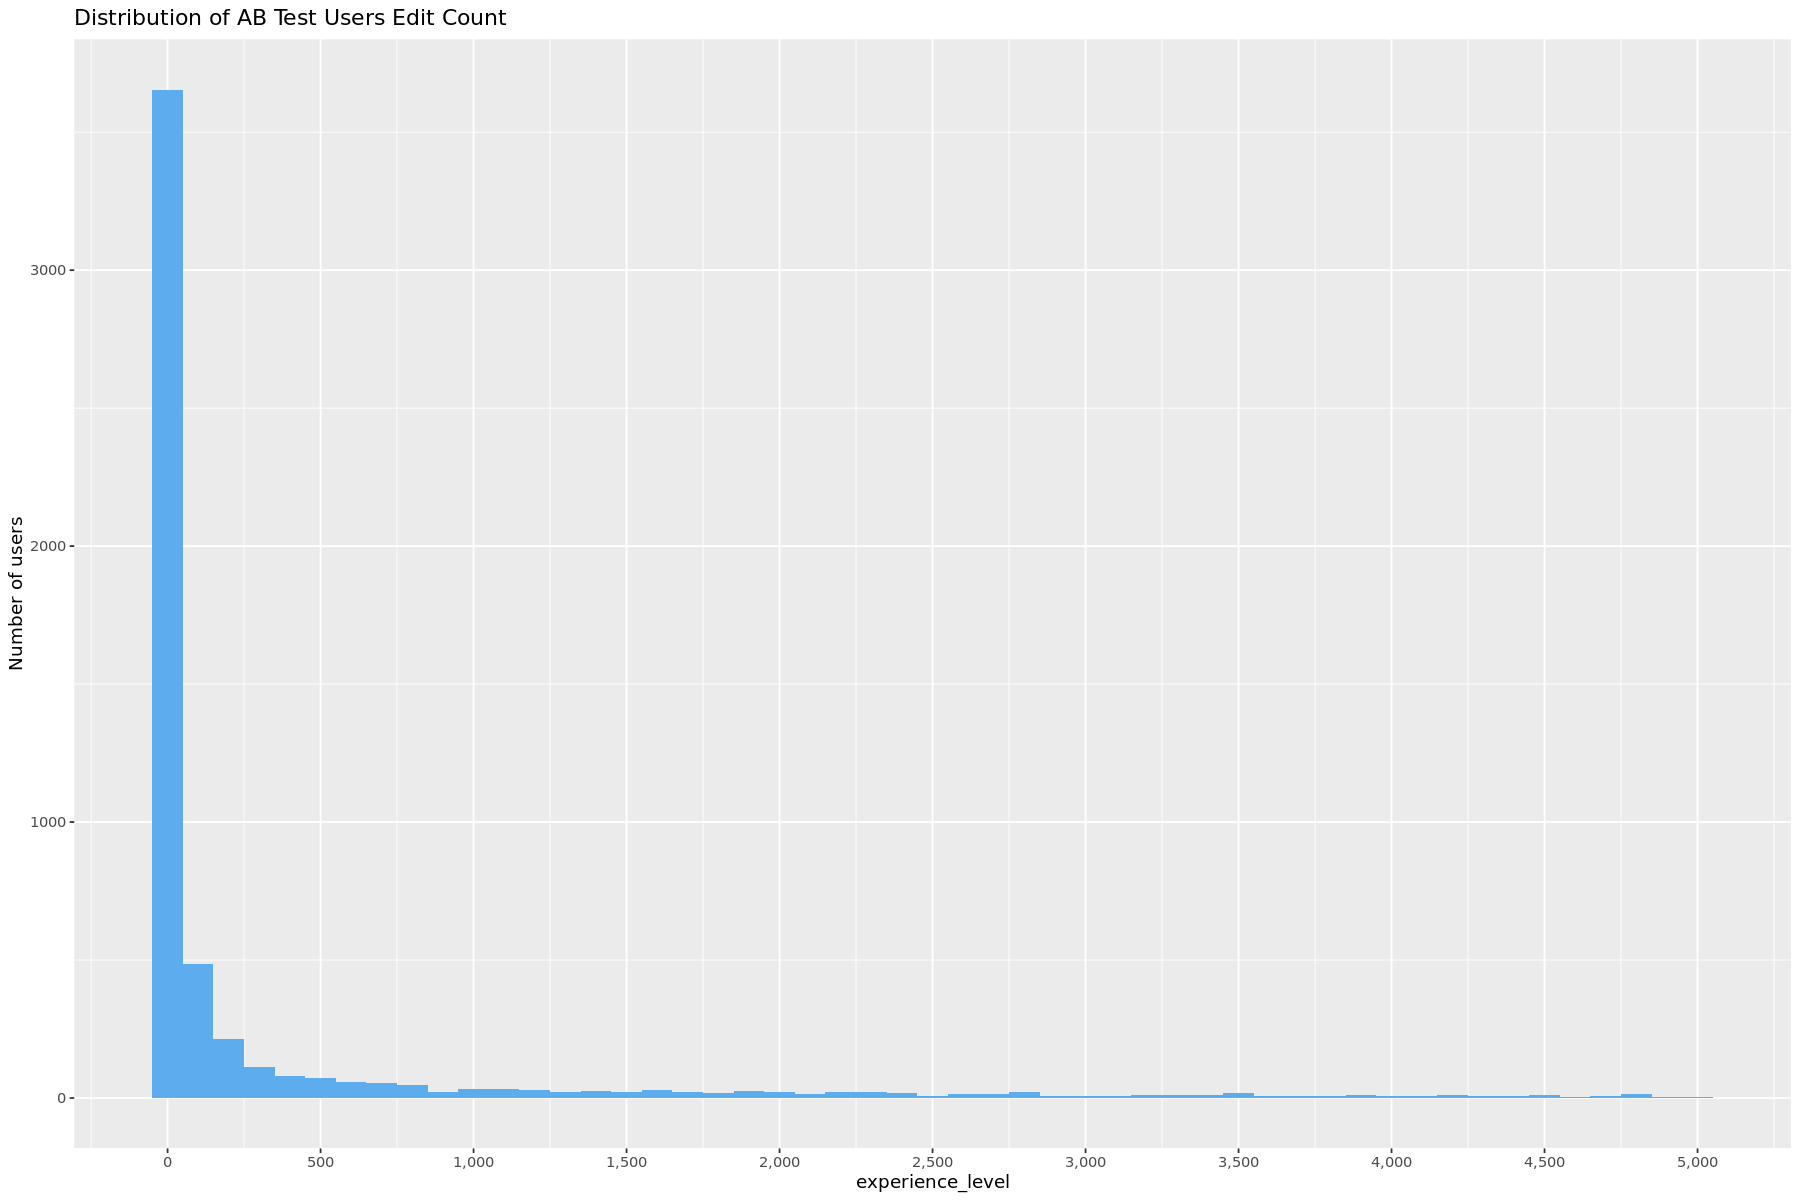

In [124]:
# Create histogram

exp_histogram <- new_topic_attempts %>%
    filter(experience_level < 5000)  %>%  #remove significant outliers to help more clearly see distribution of majority
    group_by(user_id)  %>%
    summarize(experience_level = min(experience_level)) %>% #experience level at first recorded attempt in AB test
ggplot(aes(x=experience_level)) + 
geom_histogram(binwidth = 100, fill = 'steelblue2') +
scale_x_continuous(labels = scales::comma, breaks=seq(0,5000,500)) +
    labs (title = "Distribution of AB Test Users Edit Count ",
          y = "Number of users") 

exp_histogram 

The distribution of AB test users' experience is highly left-skewed with the vast majority of users having under 500 edits with significant outliers. After 3000 edits, the number of users is minimal. We'll divide users into segments of 500[^segment size] to take a more granular look at the impact of experience level with an over 3000 group to account for the remaining outliers. 

[^segment size]:There is also a sample size issue we need to take into account. If we make the segments too small (or granular), there will not be enough events logged within that group to have a representative sample. This is expecially true for higher edit count groups where there are fewer users. We will need to make the segments large enough to include a sufficient sample size for review. 


In [91]:
# divide experiene level groups
new_topic_attempts_exp <- new_topic_attempts %>%
    mutate(experience_group = cut(as.numeric(experience_level), 
                                         breaks = c(0, 100, 500, 1000, 1500, 2000, 2500, 3000,
                                                    Inf), 
                                         labels = c('0-100 edits', '101-500 edits', '501-1000 edits', '1001-1500 edits', '1501-2000 edits', '2001-2500 edits', '2501-3000 edits',
                                                    'over 3000 edits'), include.lowest = TRUE))



In [92]:
#aggregate data to show contributors that completed at least 1 edit by experience level
new_topic_attempts_byexp <- new_topic_attempts_exp %>%
  group_by (wiki, section_edit_type, user_id, experience_group) %>%
  summarise(n_attempts = n_distinct(edit_attempt_id),
            n_completions = sum(edit_success == 'Complete'),
            edit_success = ifelse(sum(n_completions >= 1), 'Complete', 'Not Complete'),  #redefine edit success as user completed at least 1 edit
            new_topic_tool_used = as.integer(ifelse(sum(section_edit_type== 'New topic tool'), 1, 0)),
    .groups = 'drop') 


In [93]:
 #convert edit success as factor for use in the model
new_topic_attempts_byexp$edit_success <- factor(
    new_topic_attempts_byexp$edit_success,
    levels = c("Not Complete", "Complete"),
    labels = c("Not Complete", "Complete")
  )

First, we'll review the completion rate across all experience levels.

In [94]:
# Review edit completion rate by section edit type across all experience levels
new_topic_completes_allexp <- new_topic_attempts_byexp %>%
    group_by(section_edit_type) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(n_completions >= 1), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) 

In [95]:
new_topic_completes_allexp_table <- new_topic_completes_allexp %>%
  gt() %>%
  tab_header(
    title = "Contributors new topic completion rate",
    subtitle = "Across all experience levels and participating Wikipedias"
  )  %>%
  cols_label(
    section_edit_type = "Editing method",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Completion rate"
  )   %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that make a new topic attempt and publish at least 1 comment.",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "Sampling rate for Non-New Topic Tool events is 6.25%",
    locations = cells_body(
      columns = 'section_edit_type', rows = 1)
    ) %>%
  tab_footnote(
    footnote = "Sampling rate for New Topic Tool events is 100%",
    locations = cells_body(
      columns = 'section_edit_type', rows = 2)
    ) %>%
    gtsave(
    "new_topic_completes_allexp_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_completes_allexp_table.html")

1 Defined as percent of contributors that make a new topic attempt and publish at least 1 comment. 2 Sampling rate for Non-New Topic Tool events is 6.25% 3 Sampling rate for New Topic Tool events is 100%


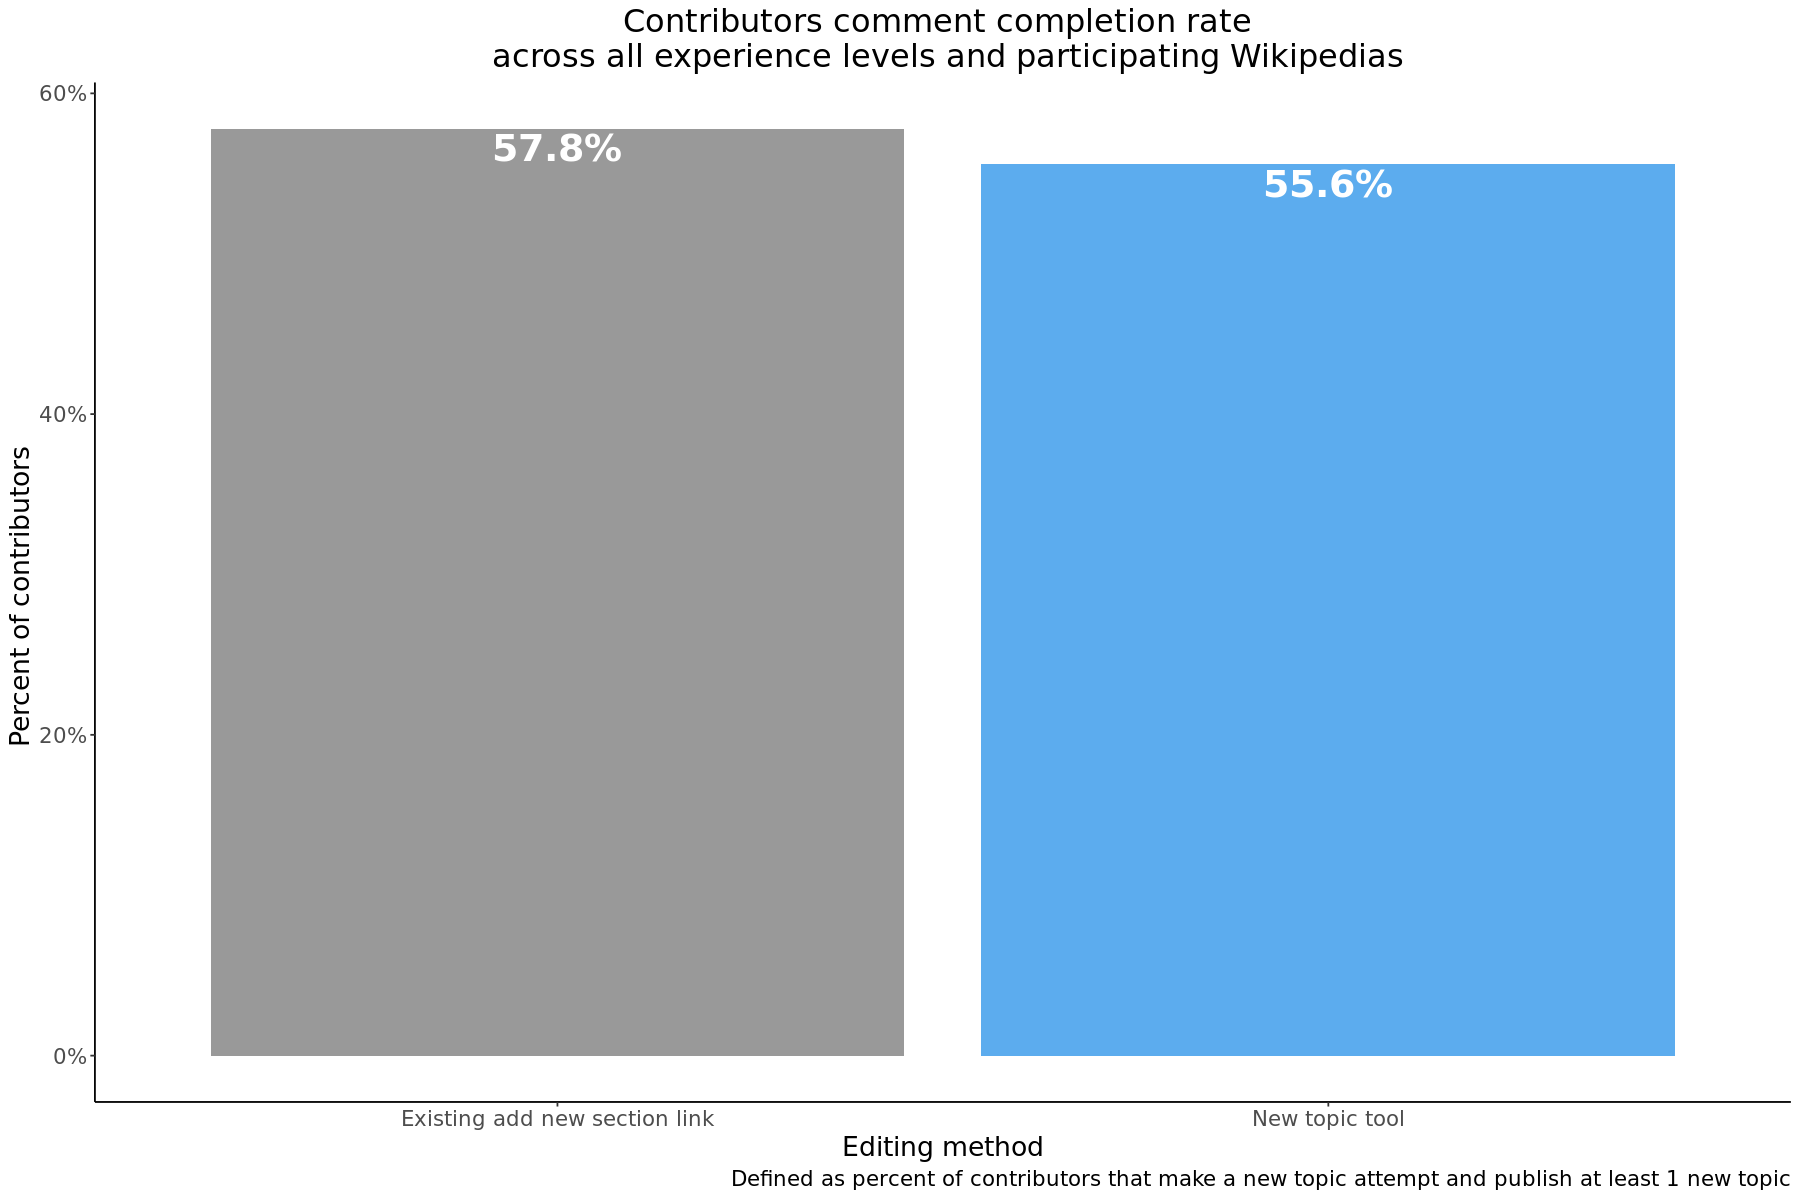

In [96]:
# Plot edit completion rates across all wikis and experience levels 

p <- new_topic_completes_allexp %>%
    ggplot(aes(x= section_edit_type, y = n_users_completed / n_users, fill = section_edit_type)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Existing add new section link", "New topic tool")) +
    labs (y = "Percent of contributors ",
          x = "Editing method",
          title = "Contributors comment completion rate \n across all experience levels and participating Wikipedias",
         caption = "Defined as percent of contributors that make a new topic attempt and publish at least 1 new topic")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 


p
ggsave("Figures/new_topic_completes_allexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

Across all contributor experience levels, there was a slight decrease (-2.4 percentage points (58% → 53.5%; 4.14% decrease) in the percent of contributors that were able to successfully publish a comment using the new topic tool compared to contributors using the existing add new section link workflow. This is different than the observed increase in Junior Contributors' new topic completion rates indicating that the experience level is a factor on the impact of the new topic tool. 

55.5% of Contributors across all experience levels were able to publish at least one new topic using the new topic tool. This is slightly higher than the percent of Junior Contributors (44.2%) that published a new topic using the new topic tool. 

However, the new topic completion rate for the existing new section link workflow is much higher when looking at Contributors across all experience levels. 58% by Contributors across all experience levels were able to complete at least one new topic using the existing add new section link workflow compared to only 36.9% of Junior Contributors.


### Comment completion rate by experience level

Next, we'll look at completion rate by each of the experience level bins.


#### New topic completion rate defined as percent of edit attempts that are successfully published

In [97]:
# Completion Rate By Session

new_topic_attempts_byexp_bysession <- new_topic_attempts_exp %>%
    group_by (experience_group, section_edit_type) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_completions = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              completion_rate = paste0(round(n_completions / n_attempts  *100, 1), "%"),
           new_topic_tool_used = as.integer(ifelse(sum(section_edit_type== 'New topic tool'), 1, 0)),
    .groups = 'drop') 

new_topic_attempts_byexp_bysession

experience_group,section_edit_type,n_attempts,n_completions,completion_rate,new_topic_tool_used
<fct>,<fct>,<int>,<int>,<chr>,<int>
0-100 edits,Existing add new section link,512,179,35%,0
0-100 edits,New topic tool,6266,2249,35.9%,1
101-500 edits,Existing add new section link,100,50,50%,0
101-500 edits,New topic tool,1813,961,53%,1
501-1000 edits,Existing add new section link,67,37,55.2%,0
501-1000 edits,New topic tool,879,484,55.1%,1
1001-1500 edits,Existing add new section link,26,12,46.2%,0
1001-1500 edits,New topic tool,509,298,58.5%,1
1501-2000 edits,Existing add new section link,20,16,80%,0


#### New topic completion rate defined as percent of contributors that complete at least 1 new topic 

In [98]:
# Review edit completion rate by contributors and experience level
new_topic_completes_byexp <- new_topic_attempts_byexp %>%
    group_by(experience_group, section_edit_type) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = n_distinct(user_id[n_completions >= 1]), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  )   %>%  #determine credible intervals
    cbind(as.data.frame(binom:::binom.bayes(x = .$n_users_completed, n = .$n_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))


In [130]:
new_topic_completes_byexp_table <- new_topic_completes_byexp %>%
 select(c(1,2,3,4,5,12,13))  %>% #remove unneeded rows
  gt() %>%
  tab_header(
    title = "Contributors new topic completion rate by experience level",
    subtitle = "Across all participating Wikipedias"
  )  %>%
  cols_label(
    experience_group = "Experience level group",
    section_edit_type = "Editing experience",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Completion rate",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  )   %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that made a new topic attempt and publish at least 1 comment.",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )) %>%
    gtsave(
    "new_topic_completes_byexp_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_completes_byexp_table.html")
new_topic_completes_byexp_table 

1 Defined as percent of contributors that made a new topic attempt and publish at least 1 comment. 2 95% credible intervals. There is a 95% probability that the parameter lies in this interval


NULL

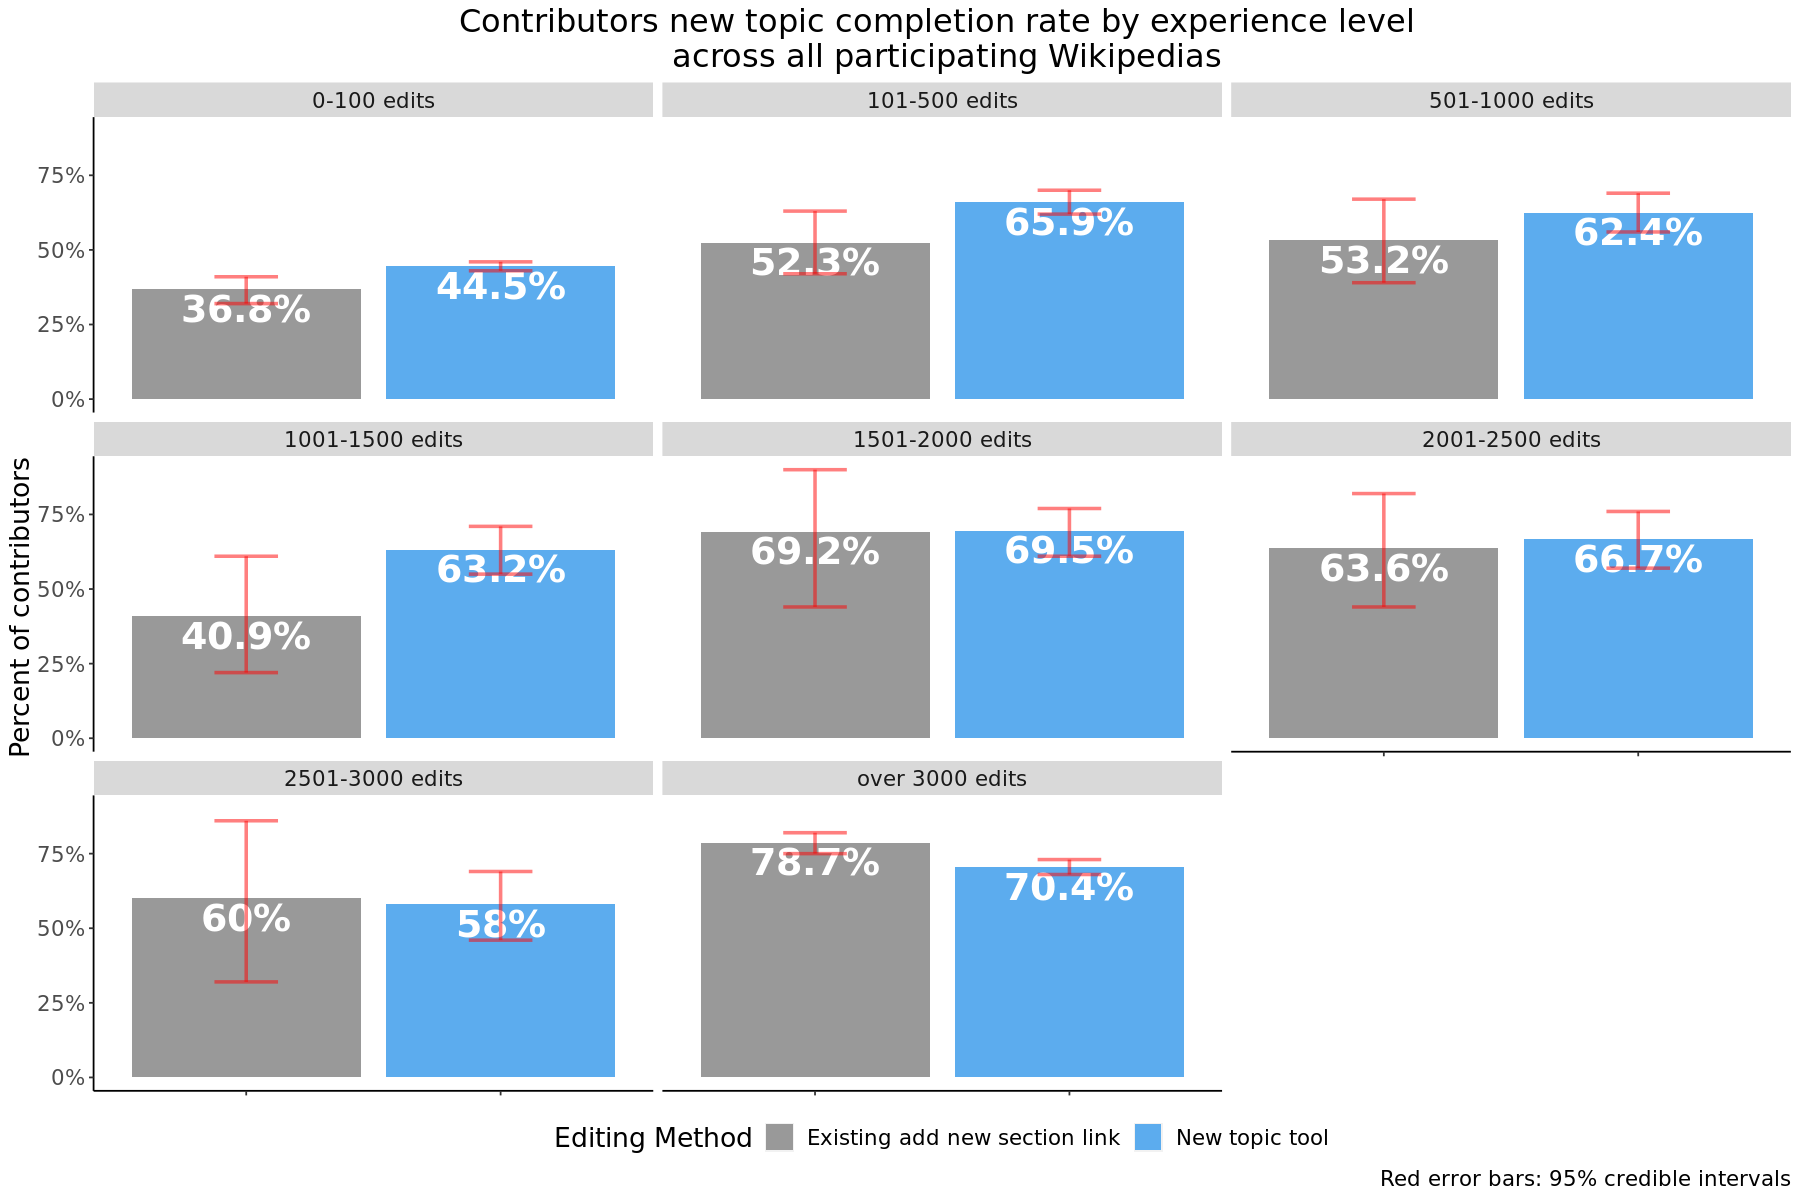

In [131]:
# Plot edit completion rates for each user on each wiki  

p <- new_topic_completes_byexp %>%
    ggplot(aes(x= section_edit_type, y = n_users_completed / n_users, fill = section_edit_type)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 8, color = "white") +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    facet_wrap(~ experience_group) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "Contributors new topic completion rate by experience level \n across all participating Wikipedias",
          caption = "Red error bars: 95% credible intervals"
          )+
      scale_fill_manual(values= c("#999999", "steelblue2"), name = "Editing Method", labels = c("Existing add new section link", "New topic tool"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p 
ggsave("Figures/new_topic_completes_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)



Observations:
* By breaking down the experience levels into more granular segments, we are able to isolate the decrease in completion rate to contributors with over 2500 edits [^errorbar].
  * There is higher new topic tool completion rate for all experience groups under 2500 cumulative edits, with percent increases ranging from only 0.4% for the 1501-2000 edit group level to a 54.5% increase for the 1001-1500 edit count group.
  * There is a see a lower new topic tool completion rate for users with over 2500 cumulative edits (-3.4% for the 2501-3000 edit count group and -10.7 for the over 3000 edit count group).

[^errorbar]: The red error bars indicate the level of uncertainty in the identifed completion rate. There is more uncertainty in the identified completion rates for higher edit count contributors using the existing add new section link. This is due to the smaller sample size available for in these groups (There are fewer users in the higher level edit counts and these events are sampled at 6.25%). However, we can confirm a slight decrease in new topic completion rate for users with over 3000 edits (with only a small level of uncertainty).

* When looking at topic completion rate by session (defined as percent of edit attempts that are successfully published), there is an even higher decrease in new topic tool completion rate for users with over 3000 edits (-23.8 percentage points (81.5% → 57.7%; -29% decrease). This potentially indicates that there a a few power users that are making a high number of incomplete New Topic Tool edits. 

Next Step: I'll investigate the abandoment rate of Senior Contributors with over 2500 edits to help determine if the decrease is a result of these contributors preferring the legacy experience rather than deficiencies in the New Topic Tool.


## Modeling the impact of the new topic tool 

Since new topic completion rates seem to vary based on the Contributor's experience level, we adjusted the Bayesian Hierarchical Regression Model to include the Contributors' experience level (junior or non-junior) as an interaction term in the model in addition to the effects of the user and wiki on comment completion rate.

In [ ]:
fit_all <- brm(
  edit_success ~ section_edit_type * is_junior + (1 | wiki/user_id), 
  family = bernoulli(link = "logit"),
  data = new_topic_attempts_byexp, 
  prior = priors,
  chains = 4, cores = 4
)

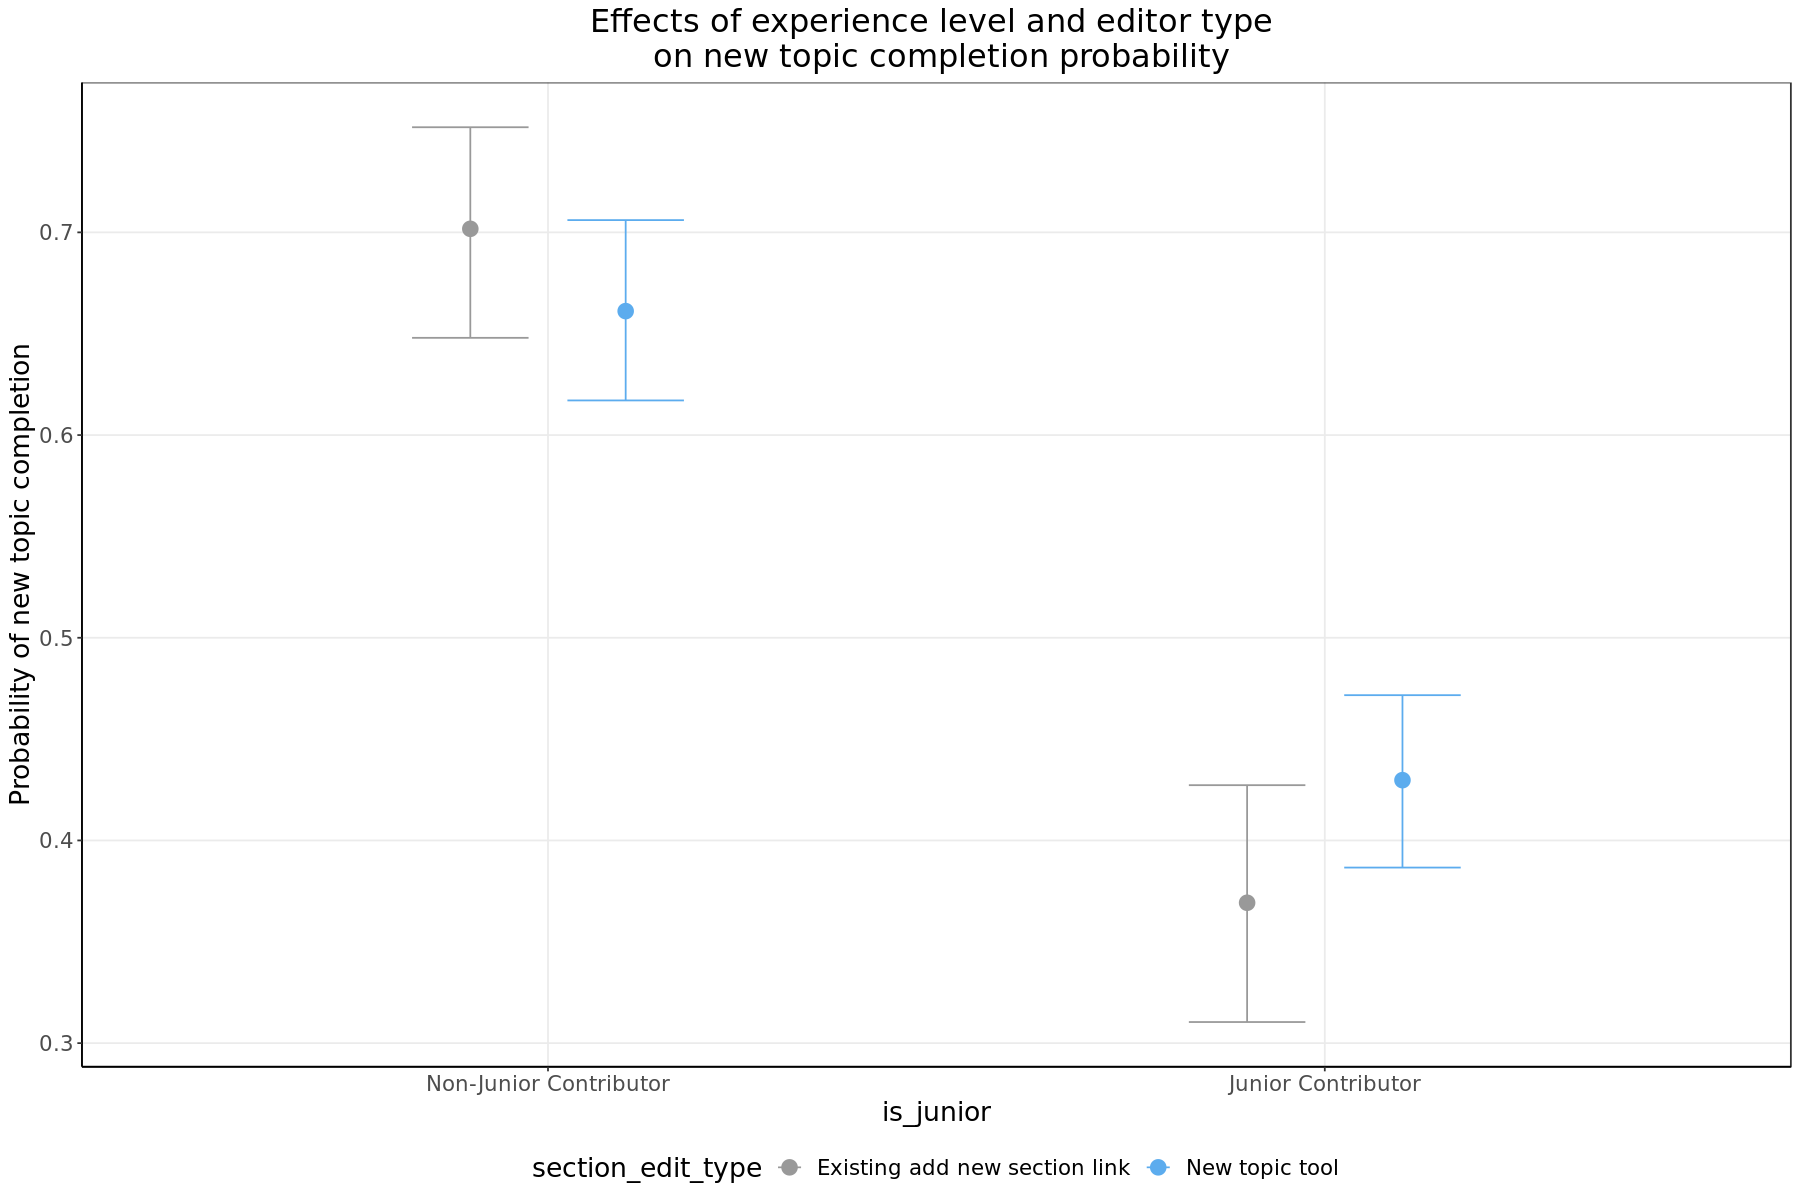

In [149]:
conditional_effects <- conditional_effects(fit_all, effects = "is_junior:section_edit_type")
p <-  plot(conditional_effects, plot = FALSE)[[1]] +
  labs (y = "Probability of new topic completion",
          title = "Effects of experience level and editor type \n on new topic completion probability")  +
    theme_bw() +
   scale_color_manual(values= c("#999999", "steelblue2"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 
p
ggsave("Figures/conditional_effects_exp_editor.png", p, width = 16, height = 8, units = "in", dpi = 300) 

The above plot shows the predicted effects of the Contributor's experience level (Junior or Non-Junior) and the type of editor that the used (new topic tool and existing add section link) on the probability of successfully publishing a comment that they started on a talk page. 

Based on the model, we can confirm the following: 
- Using either section editing method, there is a signficant difference beween the probability of a Junior Contributor completing a new topic and a Non-Junior Contributor.
- A Junior Contributor using the new topic tool is more likely to complete at least one new topic than when using the existing add new section link; however, they are still much less likely to complete a new topic using either method than a Non-Junior Contributor.
- Non-Junior Contibutors using the new topic tool are less likely to complete at least one new topic than when using the existing ass new section link. Based on a review of completion rates identifed for more granular buckets of Non-Junior Contributors (documented in the previous section), we see this decrease primarily with contributors with over 2500 edits. 


# Guardrail Analyses

## New Topic Revert Rate 

We also wanted to ensure that enabling the new topic tool did not result in an increase in the number of disruptive edits being made to talk pages. 

To evaluate any disruption caused by the new topic tool, we determined the percent of new topic published to talk pages that were reverted within 48 hours and the percent of contributors blocked after making a comment to a talk page.  


### Methodology

For this analysis, we reviewed data recorded in [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) to identify the percent comments posted with the new topic tool (identified by the revision tag: `discussiontools-newtopic`) on talk pages that are reverted within 48 hours [^revert]. We joined this data with AB test data logged in editattemptstep and talk_page_edit to isolate data to the attempts included in the AB test and try to exclude any non new topic edits.

[^revert]: 48 hours is a common cutoff, as research suggests that, at least for the English Wikipedia, nearly all reverts take place within 48 hours. Source: Research: Revert. Mediawiki. https://meta.wikimedia.org/wiki/Research:Revert.

We compared the revert rate for new topics published using the new topic tool to the revert rate for new topics made using the existing add new section link worflow during the same timeframe. 


In [6]:
new_topic_reverts <-
  read.csv(
    file = 'Data/new_topic_reverts.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [7]:
#clarfiy levels and lables for factor variables
new_topic_reverts$section_edit_type <-
  factor(
    new_topic_reverts$section_edit_type,
    levels = c("non-new-topic-tool", "new-topic-tool"),
    labels = c("Existing add new section link", "New topic tool")
  )

new_topic_reverts$is_reverted <-
  factor(new_topic_reverts$is_reverted,
         levels = c("reverted", "not-reverted"),
         labels = c("Reverted", "Not reverted"))

#reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
new_topic_reverts$user_id <-
  as.character(paste(new_topic_reverts$user_id,new_topic_reverts$wiki,sep ="-" ))

#clarfiy wiki names
new_topic_reverts <- new_topic_reverts %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'amwiki' ~ "Amharic Wikipedia",
      wiki == 'bnwiki' ~ "Bengali Wikipedia",
      wiki == 'zhwiki' ~ "Chinese Wikipedia",
      wiki == 'nlwiki' ~ 'Dutch Wikipedia',
      wiki == 'arzwiki' ~ 'Egyptian Wikipedia',
      wiki == 'frwiki' ~ 'French Wikipedia',
      wiki == 'hewiki' ~ 'Hebrew Wikipedia',
      wiki == 'hiwiki' ~ 'Hindi Wikipedia',
      wiki == 'idwiki' ~ 'Indonesian Wikipedia',
      wiki == 'itwiki' ~ 'Italian Wikipedia',  
      wiki == 'jawiki' ~ 'Japanese Wikipedia',   
      wiki == 'kowiki' ~ 'Korean Wikipedia',
      wiki == 'omwiki' ~ 'Oromo Wikipedia', 
      wiki == 'fawiki' ~ 'Persian Wikipedia',  
      wiki == 'plwiki' ~ 'Polish Wikipedia',   
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
      wiki == 'eswiki' ~ 'Spanish Wikipedia',
      wiki == 'thwiki' ~ 'Thai Wikipedia',  
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia',
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia',    
    )
  ) 

In [9]:
# Create new column to identify Junior and Non-Junior Contributors

new_topic_reverts <- new_topic_reverts %>%
  mutate(
    is_junior = case_when(
      #clarfiy participating project names
      experience_level < 100 ~ "Junior Contributor",
      experience_level >=  100 ~ "Non-Junior Contributor"   
    ),
    is_junior = factor(is_junior,
         levels = c("Non-Junior Contributor", "Junior Contributor")
   ))


### Junior Contributor revert rate

#### Overall revert rate across all participating Wikipedias

In [15]:
# filter date to only look at junior contributor edits reverted
new_topic_reverts_jc <- new_topic_reverts %>%
    filter(is_junior == 'Junior Contributor') 

In [16]:
# aggregrate based on editing experience type
new_topic_reverts_jc_all <- new_topic_reverts_jc %>%
    group_by(section_edit_type) %>%
    summarise(total_reverts = n_distinct(revision_id[is_reverted == "Reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate =paste(round(total_reverts/total_comments * 100, 2), '%'), .groups = 'drop')  %>%
    ungroup()  %>%
    cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_comments, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))

In [19]:
new_topic_reverts_jc_all_table <- new_topic_reverts_jc_all %>%
  select(c(1,2,3,4,11,12))  %>% #remove unneeded rows
  gt()  %>%
  tab_header(
    title = "Junior contributors new topic revert rate across all participating Wikipedias",
    subtitle = "Across all participating Wikipedias"
  )  %>%
  cols_label(
    section_edit_type = "Editing experience",
    total_reverts = "Number of new topics reverted",
    total_comments = "Number of new topics published",
    revert_rate = "Revert rate",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of new topics reverted within 48 hours.",
    locations = cells_column_labels(
      columns = 'revert_rate'
    )
  )  %>%
  tab_footnote(
    footnote = "Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events",
    locations = cells_column_labels(
      columns = 'section_edit_type'
    )
  ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )
  ) %>%
    gtsave(
    "new_topic_reverts_jc_all_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_reverts_jc_all_table.html")



1 Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events 2 Defined as percent of new topics reverted within 48 hours. 3 95% credible intervals. There is a 95% probability that the parameter lies in this interval


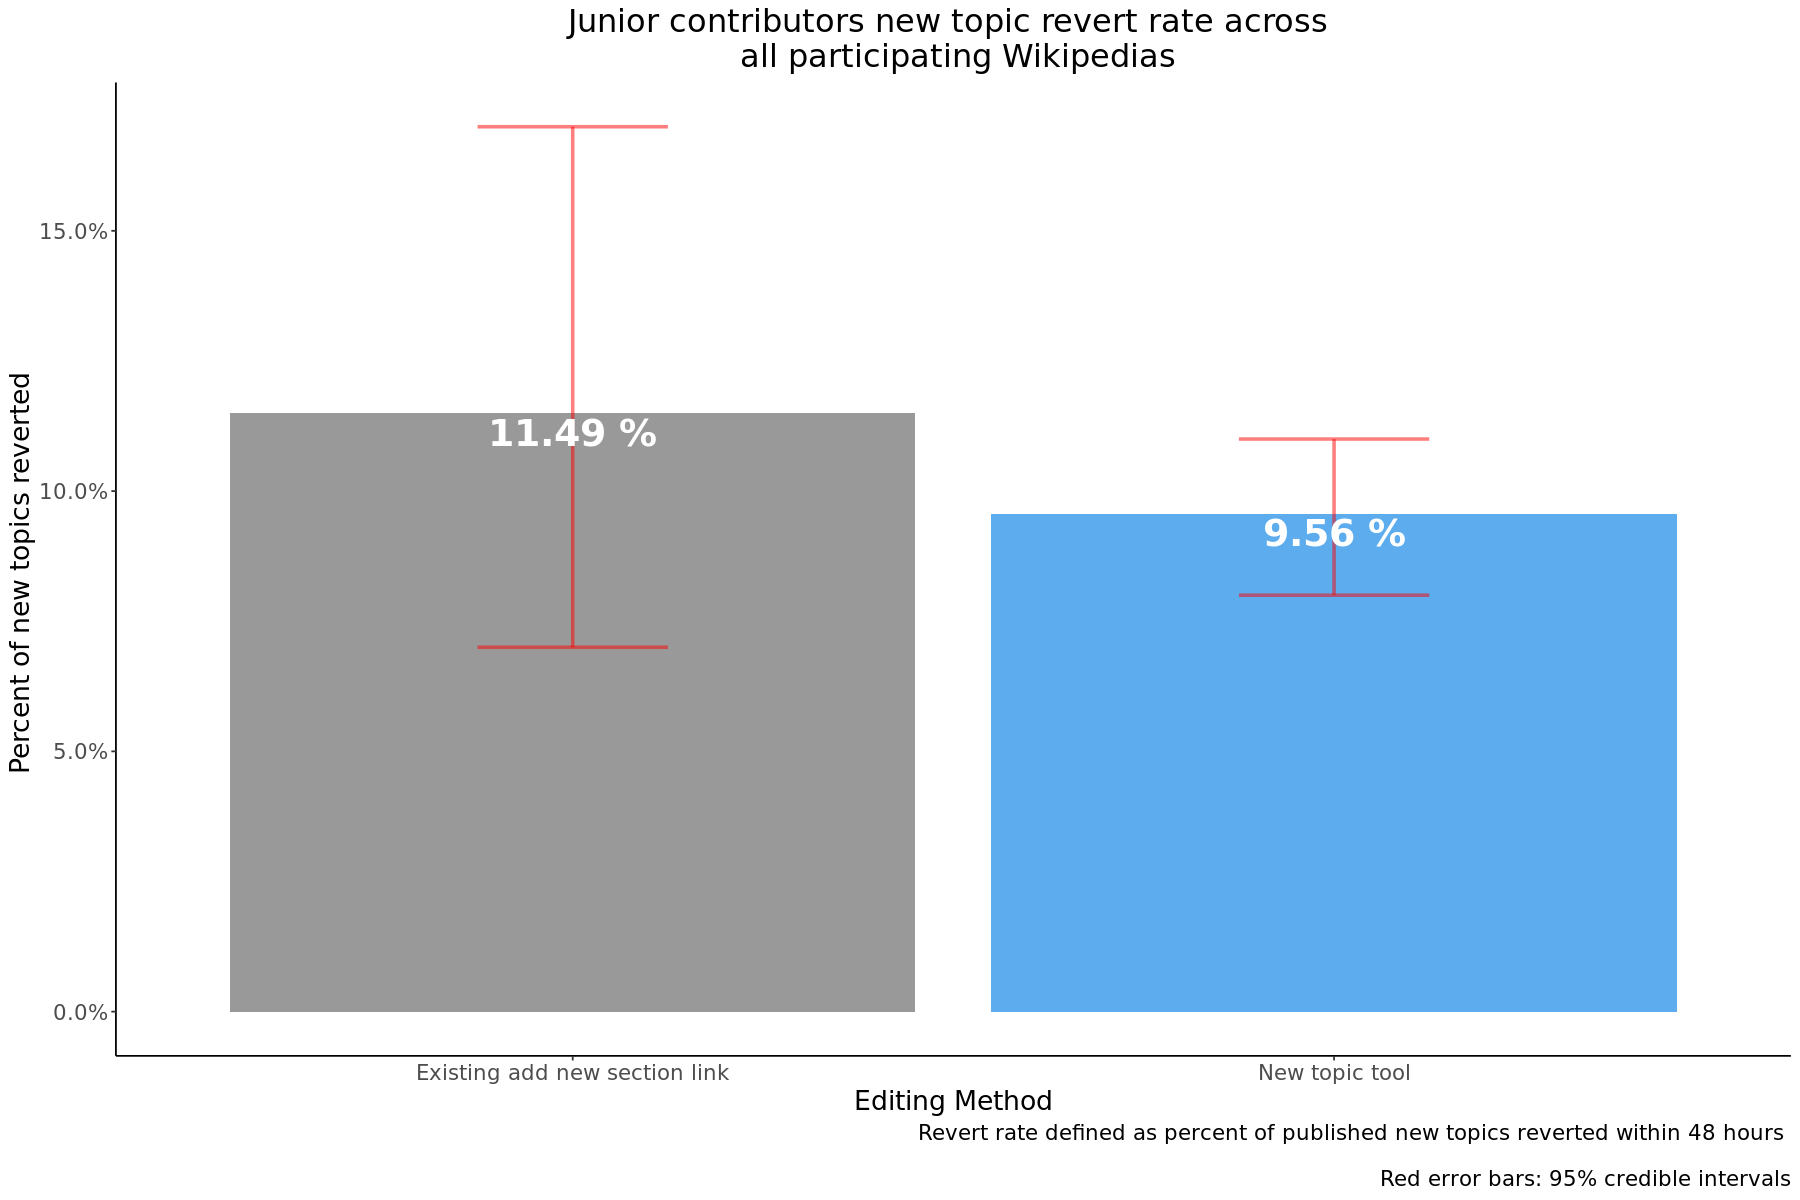

In [24]:
# Plot edit completion rates for each user on each wiki  

dodge <- position_dodge(width=0.9)

p <- new_topic_reverts_jc_all %>%
    ggplot(aes(x= section_edit_type, y = total_reverts/ total_comments, fill = section_edit_type)) +
    geom_col(position = 'dodge') +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    geom_text(aes(label = paste(revert_rate), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Existing add new section link", "New topic tool")) +
    labs (y = "Percent of new topics reverted ",
          x = "Editing Method",
          title = "Junior contributors new topic revert rate across \n all participating Wikipedias",
         caption = "Revert rate defined as percent of published new topics reverted within 48 hours \n
            Red error bars: 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
         plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black"))
p


ggsave("Figures/new_topic_reverts_jc_all .png", p, width = 16, height = 8, units = "in", dpi = 300)

Overall, across all participating Wikipedias, we observed a -1.9 percentage point (11.5% → 9.6%; 16.80% decrease) in the revert rate for new topic tool edits made by Junior Contributors compared to edits made using the previous add section link. In addition to increasing the likelihood of a Junior Contributor saving a new topic, the new topic tool also appears to reduce the number of errors in the published new topic that might lead to the new topic being reverted. 

It is important to note that there is high level of uncertaininty in the revert rate identified for the exisisting add new section link as indicated by the red error bar in the chart above. This is due to the smaller numer of events available to review for this editing method. Running the AB test for longer or increasing the sampling rate for non new topic tool events would help reduce this level of uncertainty. However, looking at the possible interval of values indicated by the error bar, the revert rate is unlikely to be signficantly lower than the new topic tool.

#### Revert rate by participating Wikipedia

In [26]:
# aggregrate data by wiki and editing interface
new_topic_reverts_jc_bywiki <- new_topic_reverts_jc %>%
    group_by(wiki, section_edit_type) %>%
    summarise(total_reverts = n_distinct(revision_id[is_reverted == "Reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate =paste(round(total_reverts/total_comments * 100, 2), '%'), .groups = 'drop')%>%
    cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_comments, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))

In [27]:
new_topic_reverts_jc_bywiki_table <- new_topic_reverts_jc_bywiki   %>%
 select(c(1,2,3,4,5,12,13))  %>% #remove unneeded rows
  gt()  %>%
  tab_header(
    title = "Junior Contributors new topic revert rate by participating Wikipedia"
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    section_edit_type = "Editing method",
    total_reverts = "Number of new topics reverted",
    total_comments = "Number of new topics published",
    revert_rate = "Revert rate",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of new topics reverted within 48 hours.",
    locations = cells_column_labels(
      columns = 'revert_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events",
    locations = cells_column_labels(
      columns = 'section_edit_type'
    )
  ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )
  ) %>%
    gtsave(
    "new_topic_reverts_jc_bywiki_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_reverts_jc_bywiki_table.html")

1 Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events 2 Defined as percent of new topics reverted within 48 hours. 3 95% credible intervals. There is a 95% probability that the parameter lies in this interval


Some per participating Wikipedia trend highlights :

* Revert rates vary on a per wiki basis. 7 out of the 20 participating wikipedias had higher new topic tool revert rates, with significantly high new topic tool revert rates observed for Bengali (20%), Indonesian (27%) and Korean (22%).
* Much of this variation is due to the signficant difference in number of events logged for each new topic edit type. Since new topic tool events were sampled at 100% and non-new topic tool events were sampled at 6.25%, some of the smaller wikis had very few number of non new topic tool events logged to obtain a representative sample. As a result, there is a lot of uncertainty around the identifed revert rates as indicated by the 95% credible intervals. 
* Additional data would be needed to confirm any per wiki revert rate differences especially for smaller wikis.

### Revert rate by experience level

To understand the impact of experience level on revert rate, we reviewed the revert rates for non-Junior Contriburtors as well using the same edit segments used for the new topic completion rate analysis.

In [44]:
# divide experience level groups
new_topic_reverts_exp <- new_topic_reverts %>%
    mutate(experience_group = cut(as.numeric(experience_level), 
                                         breaks = c(0, 100, 500, 1000, 1500, 2000, 2500, 3000,
                                                    Inf), 
                                         labels = c('0-100 edits', '101-500 edits', '501-1000 edits', '1001-1500 edits', '1501-2000 edits', '2001-2500 edits', '2501-3000 edits',
                                                    'over 3000 edits'), include.lowest = TRUE))



In [45]:
# aggregate data based on editor and experience level
new_topic_reverts_byexp <- new_topic_reverts_exp %>%
    group_by(experience_group, section_edit_type) %>%
    summarise(total_reverts = n_distinct(revision_id[is_reverted == "Reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate =paste(round(total_reverts/total_comments * 100, 2), '%'), .groups = 'drop')   %>%
    ungroup()  %>%
    cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_comments, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))

In [46]:
new_topic_reverts_byexp_table <- new_topic_reverts_byexp %>%
  select(c(1,2,3,4,5,12,13))  %>% #remove unneeded rows
  gt()  %>%
  tab_header(
    title = "Contributors new topic revert rate by experience level"
  )  %>%
  cols_label(
    experience_group = "Experience level",
    section_edit_type = "Editing method",
    total_reverts = "Number of new topics reverted",
    total_comments = "Number of new topics published",
    revert_rate = "Revert rate",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of new topics reverted within 48 hours.",
    locations = cells_column_labels(
      columns = 'revert_rate'
    )
  )%>%
  tab_footnote(
    footnote = "Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events",
    locations = cells_column_labels(
      columns = 'section_edit_type'
    )
  ) %>%
  tab_footnote(
    footnote = "Junior contributor defined as having under cumulative 100 edits. Non-Junior Contributor is defined as having over 100 cumulative edits",
    locations = cells_column_labels(
      columns = 'experience_group'
    )
  ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )
  ) %>%
    gtsave(
    "new_topic_reverts_byexp_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_reverts_byexp_table.html")

1 Junior contributor defined as having under cumulative 100 edits. Non-Junior Contributor is defined as having over 100 cumulative edits 2 Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events 3 Defined as percent of new topics reverted within 48 hours. 4 95% credible intervals. There is a 95% probability that the parameter lies in this interval


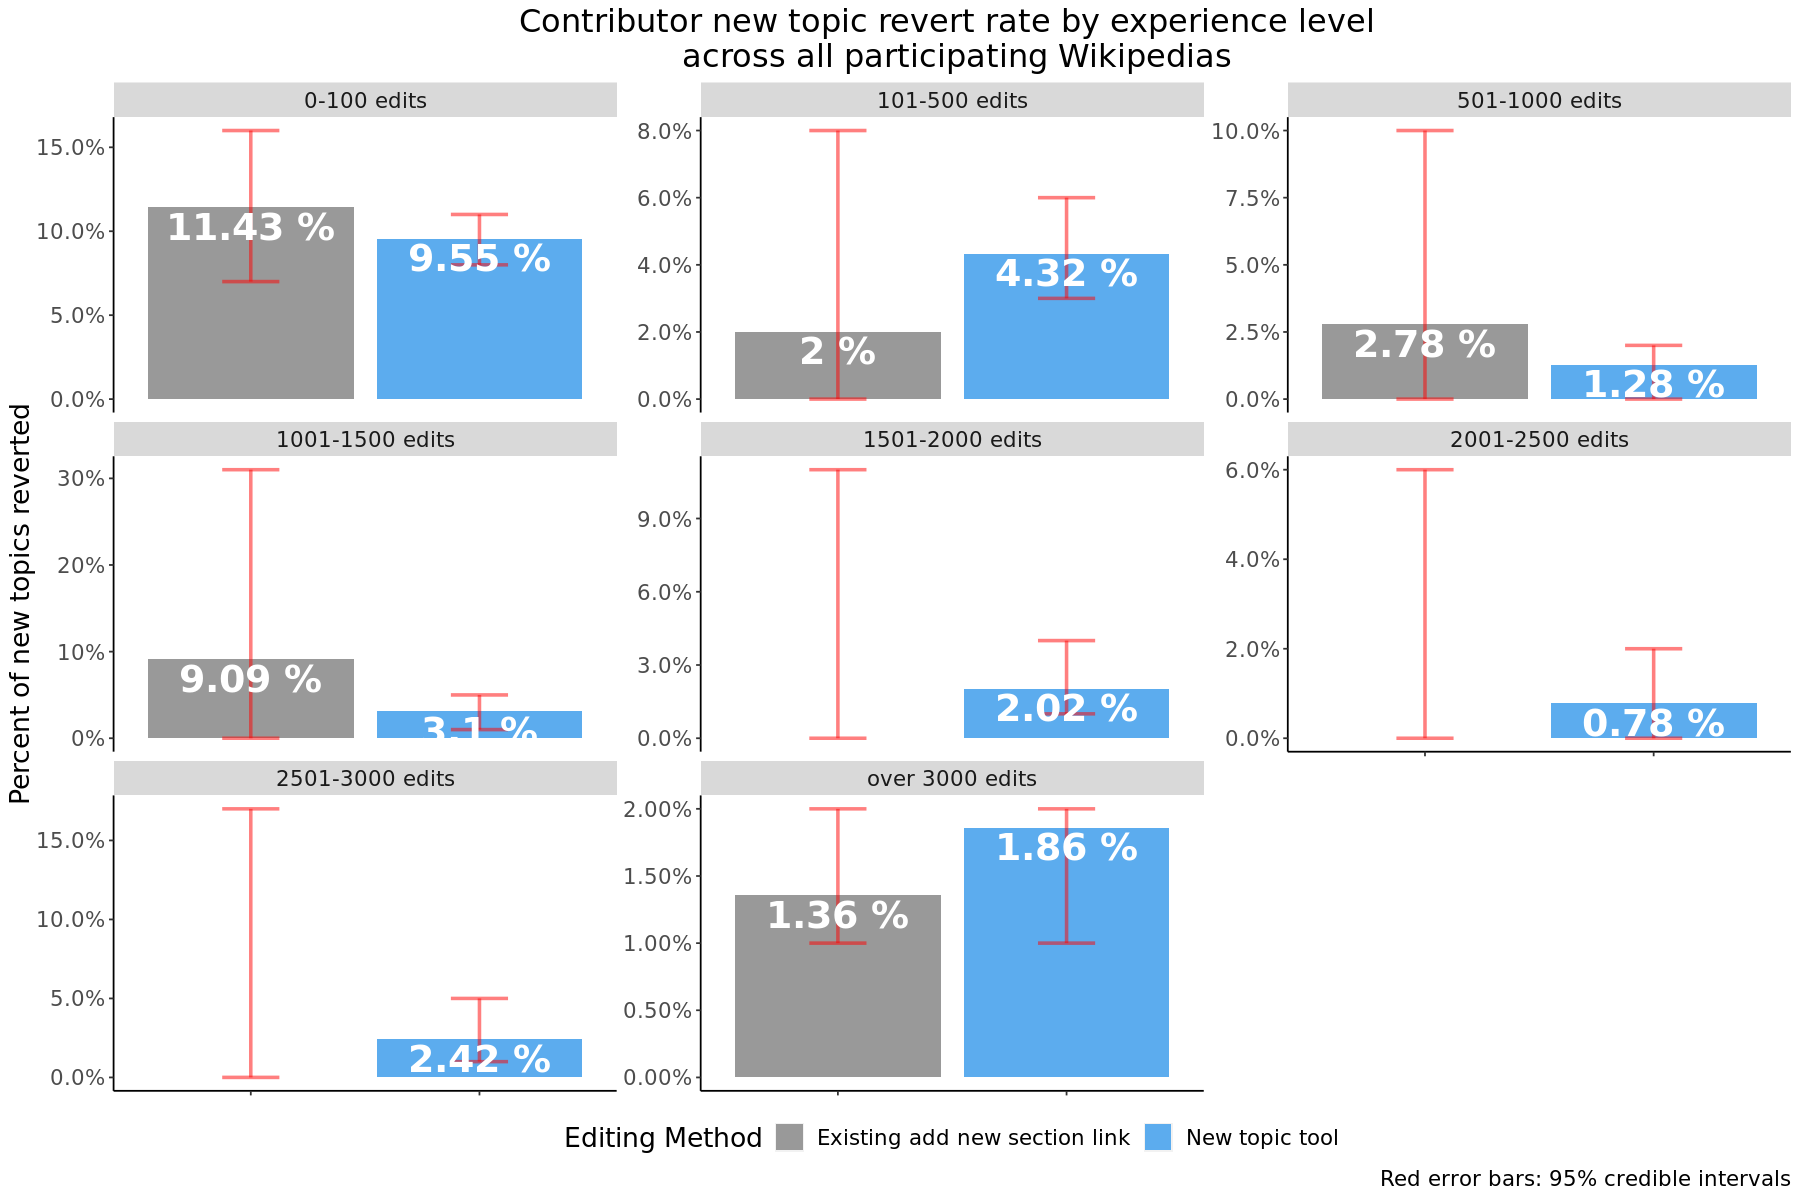

In [49]:
# plot reverts by experience

p <- new_topic_reverts_byexp  %>%
  ggplot(aes(x= section_edit_type , y = total_reverts/total_comments, fill = section_edit_type)) +
  geom_col(position = 'dodge') +
  geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', alpha = 0.5, size = 1, position = dodge, width = 0.25) +
  geom_text(aes(label = paste(revert_rate),fontface=2), vjust=1.2, size = 8, color = "white") +
  scale_y_continuous(labels = scales::percent) +
  facet_wrap(~ experience_group, scale = "free_y") +
  labs (y = "Percent of new topics reverted",
        title = "Contributor new topic revert rate by experience level \n across all participating Wikipedias",
       caption = "Red error bars: 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Editing Method", labels = c("Existing add new section link", "New topic tool"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 
p

ggsave("Figures/new_topic_reverts_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

We see a lower new topic tool revert rate for all experience groups under 1500 edits, with the exception fo the 101-500 edit count group where there see an increase in revert rate for editors with between 101-500 edits.  

Unfortunately, it is difficult to compare these revert rates with much confidence at these more granular experience levels as there are very few events logged for users at higher experience levels, especially for the existing add new section link editing method which was sampled. The low number of events logged creates more uncertainty in the identifed revert rates as indicated by the large error bars.

Excluding the edit groups where the sample sizes are too small, there was a slight increase in reverts for the over 3000 edits group (1.36% to 1.86%)

## Blocked New Topic Users
### Overall percent of Junior Contributors blocked after posting a new topic

We also reviewed the number of Junior Contributors blocked after posting a new topic using either the new topic tool or previous add new section link.

Data comes from the [mediawiki_user_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/Mediawiki_user_history) table. All block events were identified in the data by `caused_by_event_type = "alterblocks"`. The data includes any Contributors that were blocked after posting a comment; however, we do not know if they were blocked specifically due to the comment posted. Data is also currently limited to dates of the AB test. Some new topic users may have been blocked following this analysis. Similar to the revert rate methodology, we joined this data with AB test data logged in editattemptstep and talk_page_edit to isolate data to the attempts included in the AB test and try to exclude any non new topic edits.


In [50]:
new_topic_blocks <-
  read.csv(
    file = 'Data/new_topic_blocks.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [51]:
#clarfiy levels and lables for factor variables
new_topic_blocks$section_edit_type <-
  factor(
    new_topic_blocks$section_edit_type,
    levels = c("non-new-topic-tool", "new-topic-tool"),
    labels = c("Existing add new section link", "New topic tool")
  )

#clarfiy wiki names
new_topic_blocks<- new_topic_blocks%>%
   mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'amwiki' ~ "Amharic Wikipedia",
      wiki == 'bnwiki' ~ "Bengali Wikipedia",
      wiki == 'zhwiki' ~ "Chinese Wikipedia",
      wiki == 'nlwiki' ~ 'Dutch Wikipedia',
      wiki == 'arzwiki' ~ 'Egyptian Wikipedia',
      wiki == 'frwiki' ~ 'French Wikipedia',
      wiki == 'hewiki' ~ 'Hebrew Wikipedia',
      wiki == 'hiwiki' ~ 'Hindi Wikipedia',
      wiki == 'idwiki' ~ 'Indonesian Wikipedia',
      wiki == 'itwiki' ~ 'Italian Wikipedia',  
      wiki == 'jawiki' ~ 'Japanese Wikipedia',   
      wiki == 'kowiki' ~ 'Korean Wikipedia',
      wiki == 'omwiki' ~ 'Oromo Wikipedia', 
      wiki == 'fawiki' ~ 'Persian Wikipedia',  
      wiki == 'plwiki' ~ 'Polish Wikipedia',   
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
      wiki == 'eswiki' ~ 'Spanish Wikipedia',
      wiki == 'thwiki' ~ 'Thai Wikipedia',  
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia',
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia',    
    )
  ) 

In [52]:
# Create new column to identify Junior and Non-Junior Contributors

new_topic_blocks <- new_topic_blocks %>%
  mutate(
    is_junior = case_when(
      #clarfiy participating project names
      experience_level < 100 ~ "Junior Contributor",
      experience_level >=  100 ~ "Non-Junior Contributor"   
    ),
    is_junior = factor(is_junior,
         levels = c("Non-Junior Contributor", "Junior Contributor")
   ))


In [53]:
# filter date to only look at junior contributors blocked
new_topic_blocks_jc <- new_topic_blocks %>%
    filter(is_junior == 'Junior Contributor') 

In [58]:
# blocks for JCs across all wikis
new_topic_blocks_jc_all <- new_topic_blocks_jc  %>%
    group_by(section_edit_type) %>%
    summarise(total_blocked_users = sum(blocked_user),
              total_users = sum(all_users),
              pct_blocked = paste(round(total_blocked_users/total_users * 100, 2), "%"), 
              .groups = 'drop')  %>%
    ungroup()  %>%
    cbind(as.data.frame(binom:::binom.bayes(x = .$total_blocked_users, n = .$total_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))

In [61]:
new_topic_blocks_jc_all_table <- new_topic_blocks_jc_all  %>%
  select(1,2,3,4, 11, 12) %>%
  gt() %>%
  tab_header(
    title = "Junior contributors blocked after publishing a new topic "
  )  %>%
  cols_label(
    section_edit_type = "Editing method",
    total_blocked_users = "Number of users blocked",
    total_users = "Number of users that published a new topic",
    pct_blocked = "Percent of users blocked",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%
  tab_footnote(
    footnote = "Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events",
    locations = cells_column_labels(
      columns = 'section_edit_type'
    )
  ) %>%
  tab_footnote(
    footnote = "Percent of junior contributors blocked after posting a new topic during the AB test",
    locations = cells_column_labels(
      columns = 'pct_blocked'
    )
  ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )
  ) %>%
    gtsave(
    "new_topic_blocks_jc_all_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_blocks_jc_all_table.html")


1 Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events 2 Percent of junior contributors blocked after posting a new topic during the AB test 3 95% credible intervals. There is a 95% probability that the parameter lies in this interval


Overall, across all participating Wikipedias, there was a -228 percentage points (4.14% → 1.98%; 52.17% decrease) in the percent of Junior Contributors blocked after posting a new topic using the new topic tool compared to the Junior Contributors using the existing add new section link.  


### Junior Contributors blocked after posting a new topic by participating Wikipedia

In [65]:
# blocked users by wiki
new_topic_blocks_jc_bywiki <- new_topic_blocks_jc %>%
    group_by(wiki, section_edit_type) %>%
    summarise(total_blocked_users = sum(blocked_user),
              total_users = sum(all_users),
              pct_blocked = paste(round(total_blocked_users/total_users * 100, 2), "%"), 
              .groups = 'drop')  %>%
    ungroup()  %>%
    cbind(as.data.frame(binom:::binom.bayes(x = .$total_blocked_users, n = .$total_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))

In [69]:
new_topic_blocks_jc_bywiki_table <- new_topic_blocks_jc_bywiki  %>%
  select(1,2,3,4,5,12,13) %>%
  gt() %>%
  tab_header(
    title = "Junior Contributors blocked after publishing a new topic by participating Wikipedia "
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    section_edit_type= "Editing method",
    total_blocked_users = "Number of users blocked",
    total_users = "Number of users that published a new topic",
    pct_blocked = "Percent of users blocked",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%

  tab_footnote(
    footnote = "Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events",
    locations = cells_column_labels(
      columns = 'section_edit_type'
    )
  ) %>%
  tab_footnote(
    footnote = "Percent of junior contributors blocked after posting a comment during the AB test",
    locations = cells_column_labels(
      columns = 'pct_blocked'
    )
  )  %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )
  ) %>%
    gtsave(
    "new_topic_blocks_jc_bywiki_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_blocks_jc_bywiki_table.html")



1 Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool events 2 Percent of junior contributors blocked after posting a comment during the AB test 3 95% credible intervals. There is a 95% probability that the parameter lies in this interval


On a per Wikipedia basis, under 5% of all Junior Contributors that used the new topic tool were blocked with the exception of Bengali Wikipedia (6.67%) and Indonesian Wikipedia (6.52%). Note Bengali Wikipedia only had 15 distinct Junior Contributors that used the new topic tool during the AB test, which is small and likely not a representative sample. 

Please refer to the 95% credible intervals in the table above to see the level of uncertainty associated with each value.

### Blocked contributors overall by experience level

To understand the impact of experience level on blocks, we reviewed the number of blocks for non-Junior contributors as well using the same edit segments used for the new topic completion rate and revert rate analyses above.

In [70]:
# divide experience level groups
new_topic_blocks_exp <- new_topic_blocks %>%
    mutate(experience_group = cut(as.numeric(experience_level), 
                                         breaks = c(0, 100, 500, 1000, 1500, 2000, 2500, 3000,
                                                    Inf), 
                                         labels = c('0-100 edits', '101-500 edits', '501-1000 edits', '1001-1500 edits', '1501-2000 edits', '2001-2500 edits', '2501-3000 edits',
                                                    'over 3000 edits'), include.lowest = TRUE))


In [77]:
new_topic_blocks_byexp <- new_topic_blocks_exp %>%
    group_by(section_edit_type, experience_group) %>%
    summarise(total_blocked_users = sum(blocked_user),
              total_users = sum(all_users),
              pct_blocked = paste(round(total_blocked_users/total_users * 100, 2), "%")
              , .groups = 'drop')  %>%
    ungroup()  %>%
    cbind(as.data.frame(binom:::binom.bayes(x = .$total_blocked_users, n = .$total_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))


In [78]:
head(new_topic_blocks_byexp)

,section_edit_type,experience_group,total_blocked_users,total_users,pct_blocked,method,x,n,shape1,shape2,mean,lower,upper,sig
,<fct>,<fct>,<int>,<int>,<chr>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Existing add new section link,0-100 edits,7,170,4.12 %,bayes,7,170,7.5,163.5,0.04385965,0.02,0.07,0.05
2,Existing add new section link,101-500 edits,1,43,2.33 %,bayes,1,43,1.5,42.5,0.03409091,0.00,0.09,0.05
3,Existing add new section link,501-1000 edits,1,23,4.35 %,bayes,1,23,1.5,22.5,0.06250000,0.00,0.16,0.05
4,Existing add new section link,1001-1500 edits,0,8,0 %,bayes,0,8,0.5,8.5,0.05555556,0.00,0.21,0.05
5,Existing add new section link,1501-2000 edits,0,10,0 %,bayes,0,10,0.5,10.5,0.04545455,0.00,0.17,0.05
6,Existing add new section link,2001-2500 edits,0,13,0 %,bayes,0,13,0.5,13.5,0.03571429,0.00,0.13,0.05


In [81]:
new_topic_blocks_byexp_table <- new_topic_blocks_byexp  %>%
  select(1,2,3,4,5, 12,13)  %>%
  gt() %>%
  tab_header(
    title = "Contributors blocked after publishing a new topic by experience level",
  )   %>%
  cols_label(
    section_edit_type = "Editing method",
    experience_group = "Experience level",
    total_blocked_users = "Number of users blocked",
    total_users = "Number of users that saved a new topic",
    pct_blocked = "Percent of users blocked",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%

  tab_footnote(
    footnote = "Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool event",
    locations = cells_column_labels(
      columns = 'section_edit_type'
    )
  ) %>%
  tab_footnote(
    footnote = "Percent of contributors blocked after posting a new topic during the AB test",
    locations = cells_column_labels(
      columns = 'pct_blocked'
    )
  )  %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )
  ) %>%
    gtsave(
    "new_topic_blocks_byexp_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "new_topic_blocks_byexp_table.html")


1 Sampling rate is 100% for new topic tool events and 6.25% for non-new topic tool event 2 Percent of contributors blocked after posting a new topic during the AB test 3 95% credible intervals. There is a 95% probability that the parameter lies in this interval


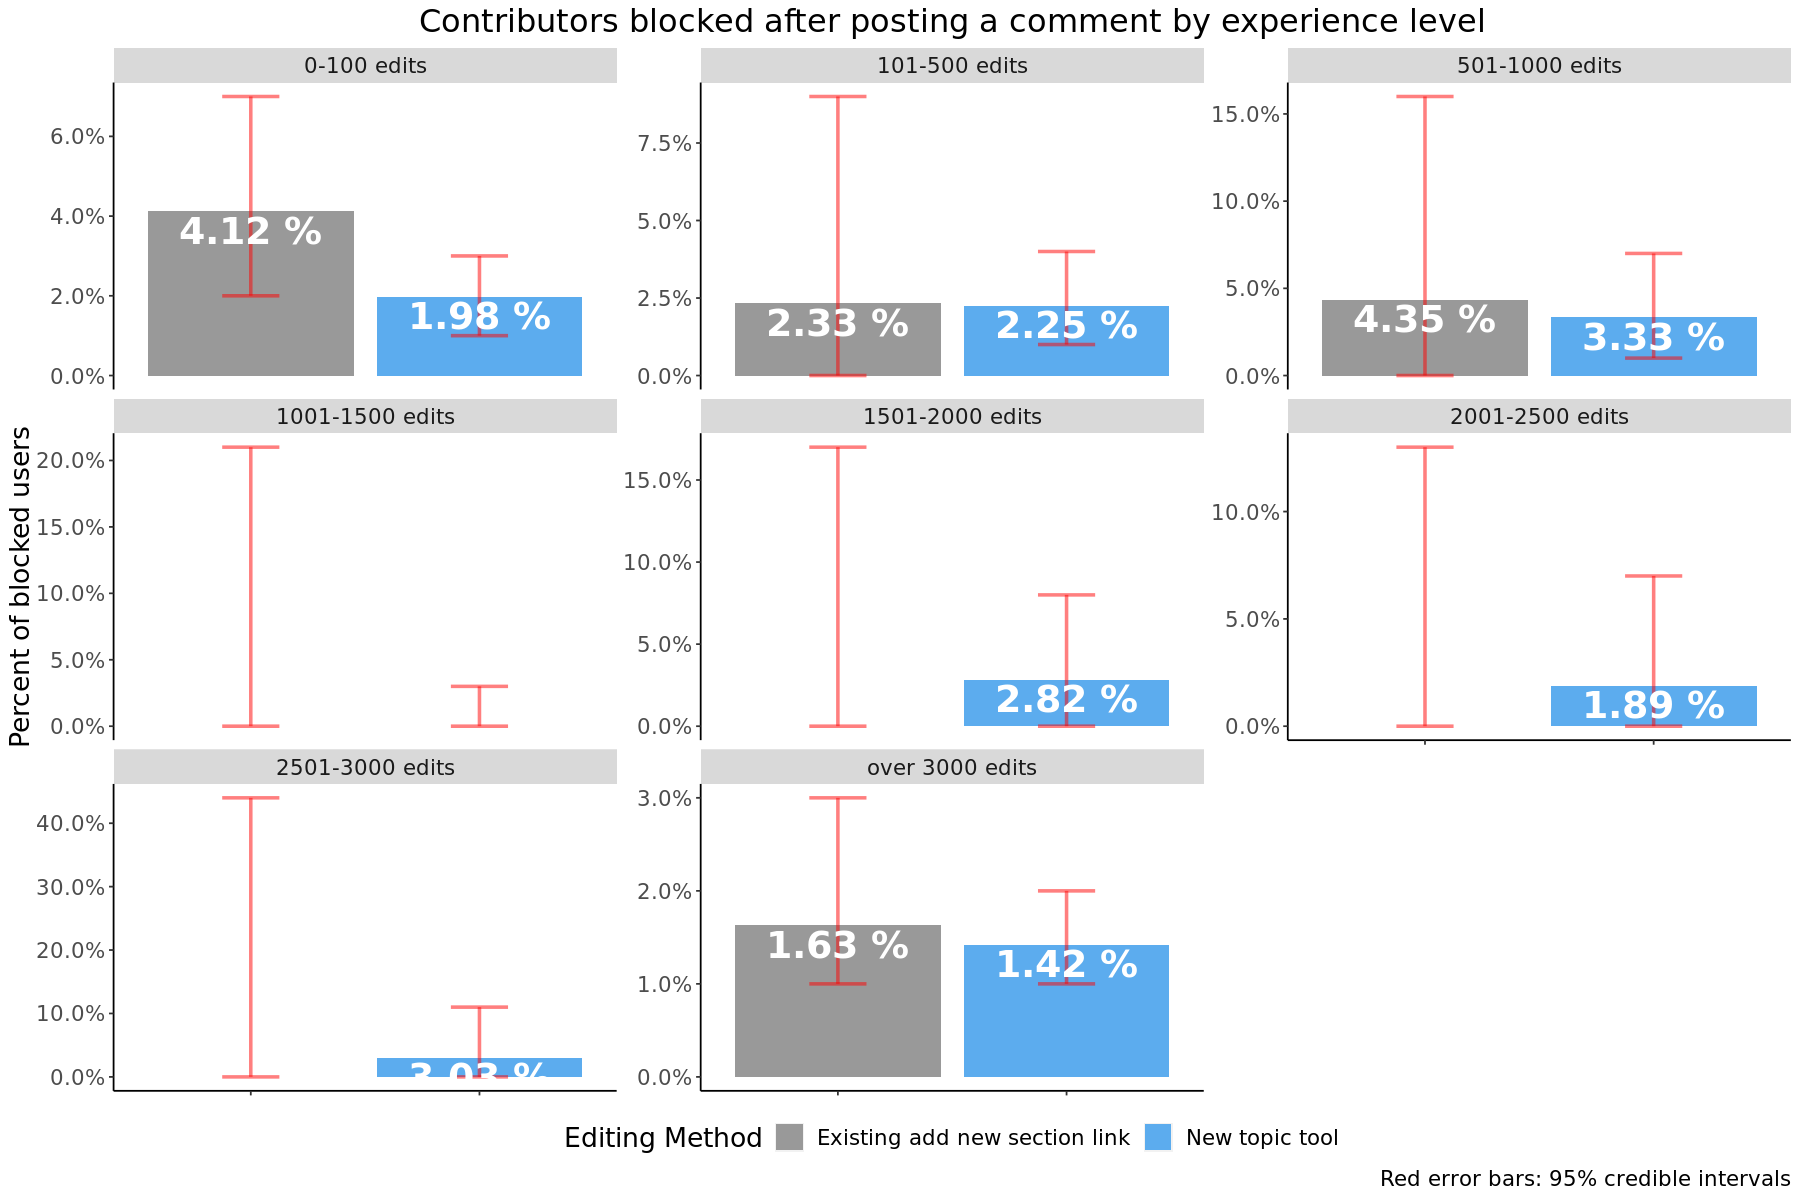

In [83]:
# plot proportion of blocks by experience levels

p <- new_topic_blocks_byexp  %>%
  ggplot(aes(x= section_edit_type, y = total_blocked_users/total_users, fill = section_edit_type,)) +
  geom_col(position = 'dodge') +
  geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', alpha = 0.5, size = 1, position = dodge, width = 0.25) +
  geom_text(aes(label = paste(pct_blocked), fontface=2), vjust=1.2, size = 8, color = "white") +
  scale_y_continuous(labels = scales::percent) +
  facet_wrap(~ experience_group, scale = "free_y") +
  labs (y = "Percent of blocked users",
        x = "Editing experience",
        title = "Contributors blocked after posting a comment by experience level",
       caption = "Red error bars: 95% credible intervals")  +
  scale_fill_manual(values= c("#999999", "steelblue2"), name = "Editing Method", labels = c("Existing add new section link", "New topic tool"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/new_topic_blocks_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)


This is not sufficient data to draw any comparison between blocked rates for these more granular editing groups. The small number of recorded blocked events especically for the existing add new section link creates a high degree of uncertainty in the identified values as representative of the actual population. 

For new topic tool usage (where sampling rates are higher), there is a lower level of uncertainty and the blocked rates from all editor groups are below 4% and below the identifed blocked percentages for the existing add new section link method (for groups where blocks were recorded).


# Curiosities

We also explored if the new topic tool resulted in a greater number of Junior Contributors to start participating productively on talk pages and if it caused a greater percentage of Junior Contributors to continue participating productively on talk pages.

## Number of Junior Contributors

This metric was defined as the number of distinct Junior Contributors who make at least one new topic edit to a page in a talk namespace during the AB test. Since different sampling rates were applied to each editor type in the AB test, we removed any events that were oversampled (sampling rate increased to 100%) to allow us to directly compare the numbers between the two groups.


In [84]:
num_jc_editors <- new_topic_attempts %>%
    filter(is_junior == 'Junior Contributor',
          is_oversample == 'false' ) %>% #remove oversampled events
    group_by(experiment_group, section_edit_type)  %>%
    summarise(total_users_attempt = n_distinct(user_id),
              total_users_complete = n_distinct(user_id[edit_success == 'Complete']), .groups = 'drop') 

ERROR: Error in filter(., is_junior == "Junior Contributor", is_oversample == : object 'new_topic_attempts' not found


In [152]:
num_jc_editors_table <- num_jc_editors %>%
  gt() %>%
  tab_header(
    title = "Number of Junior Contributors that made a new topic attempt during the AB test by test group and section edit type"
  )  %>%
  cols_label(
    experiment_group = "Test group",
    section_edit_type = "Editing method",
    total_users_attempt = "Number of users that attempted a new topic",
    total_users_complete = "Number of users that published a new topic"
  ) %>% 
  tab_row_group(
    rows = experiment_group == 'control'
  ) %>%
tab_row_group(
    rows = experiment_group == 'test'
  ) %>%
  tab_footnote(
    footnote = "Based on a sampling rate of 6.25% for all events. Any oversampled events were removed so data for the two editor types could be directly compared",
    locations = cells_title(
      )
  ) %>%
    gtsave(
    "num_jc_editors_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "num_jc_editors_table.html")



Warning message in if ((loc$groups %>% rlang::eval_tidy()) == "title") {:
“the condition has length > 1 and only the first element will be used”


1 Based on a sampling rate of 6.25% for all events. Any oversampled events were removed so data for the two editor types could be directly compared


A few explanations regarding the numbers above:
* There are Contributors for each editing method type in each AB test group. This is because contributors within each group also had the option to explicitly turn the tool on or off in their preferences; however, these contributors remained in the same group they were bucketed in for the duration of the test. See methodology section of this report. 

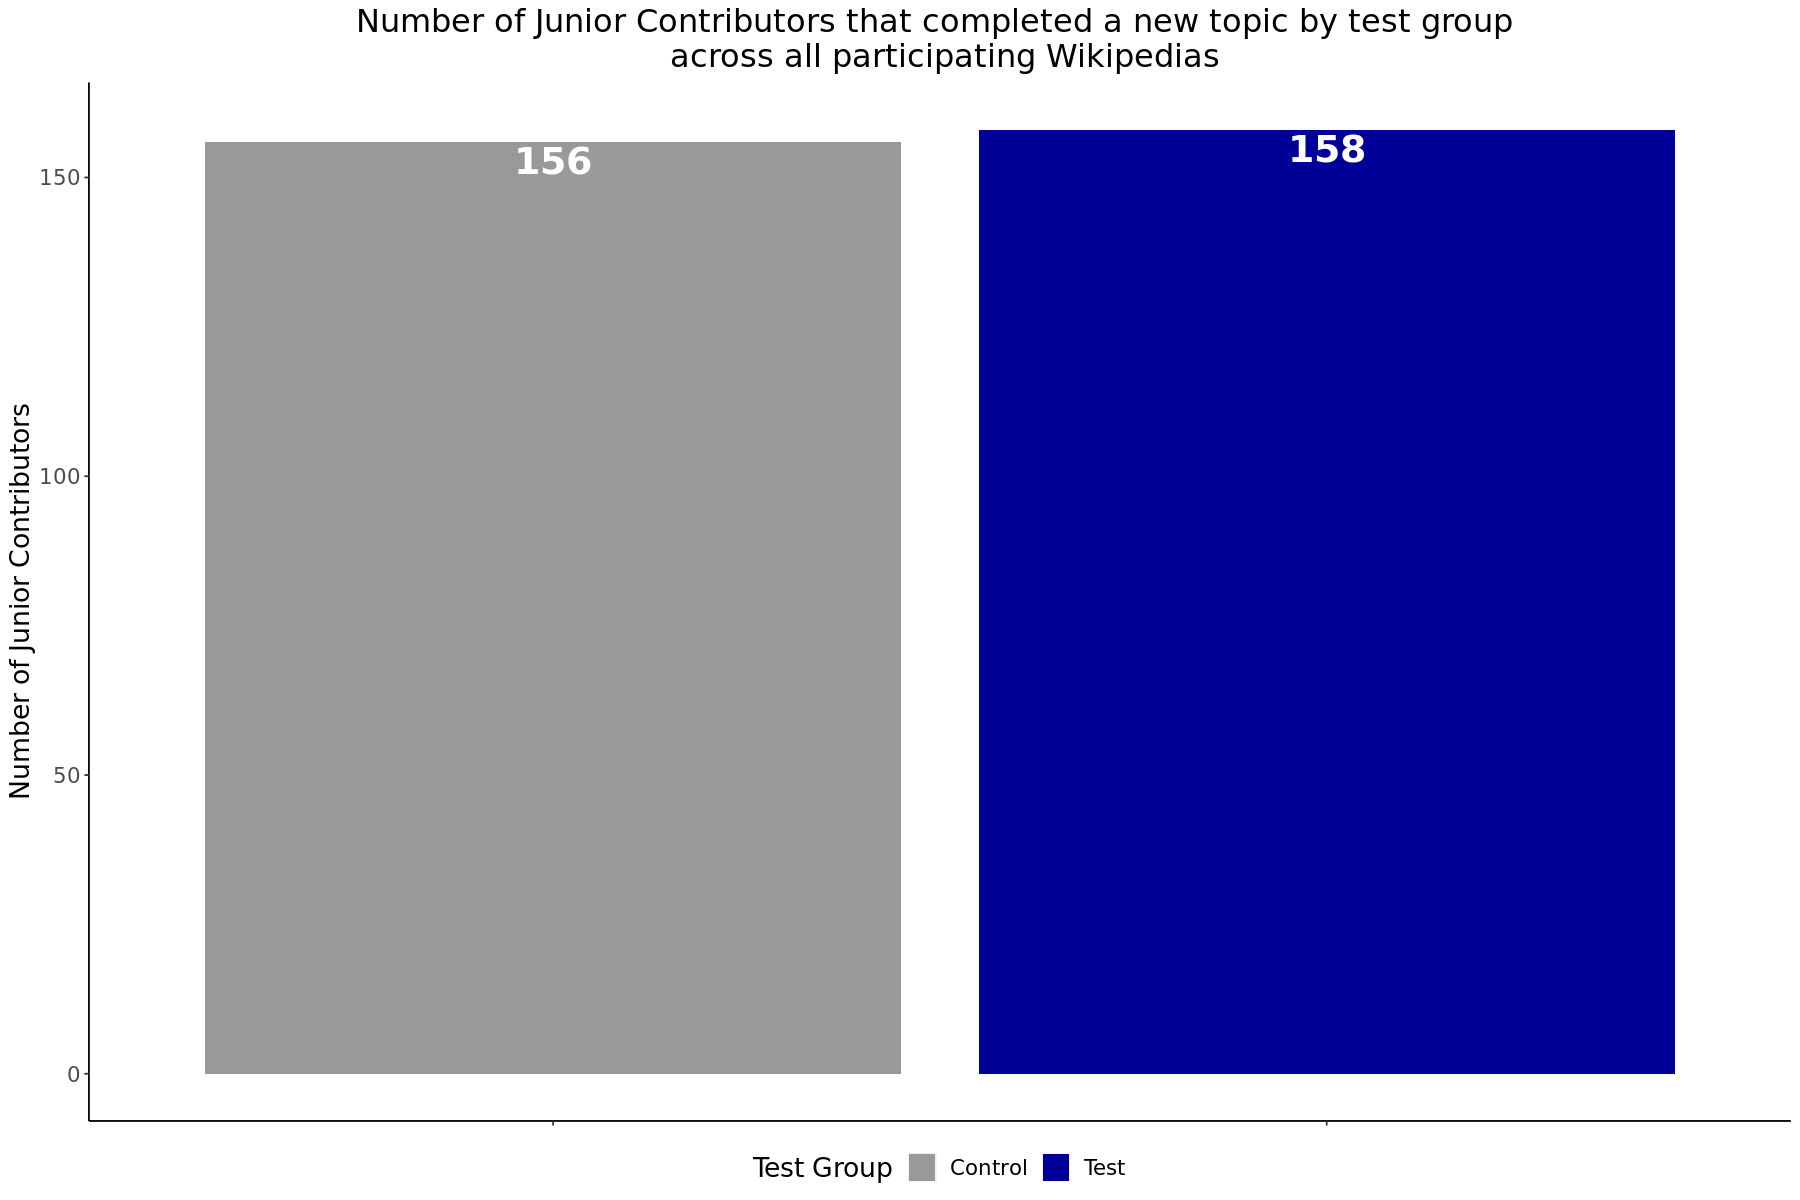

In [153]:
p <-num_jc_editors %>%
  group_by(experiment_group) %>%
  summarise(total_user_complete = sum(total_users_complete), .groups = 'drop') %>%
  ggplot(aes(x= experiment_group, y = total_user_complete, fill = experiment_group)) +
  geom_col(position = 'dodge') +
  geom_text(aes(label = paste(total_user_complete),fontface=2), vjust=1.2, size = 8, color = "white") +
  labs (y = "Number of Junior Contributors",
        x = "Experiment group",
        title = "Number of Junior Contributors that completed a new topic by test group \n across all participating Wikipedias")  +
  scale_fill_manual(values= c("#999999", "#000099"), name = "Test Group", labels = c("Control", "Test"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/num_jc_editors_bygroup.png", p, width = 16, height = 8, units = "in", dpi = 300)

The new topic tool did not impact the number of Junior Contributors that completed a new topic in either experiment group. Only 2 more distinct users were recorded as making a new topic edit in the test group compared to the control group.

## Retention of Junior Contributors

In addition, we looked into whether Junior Contributors that made at least one new topic edit during the time of the AB test (our cohort) returned to make another edit (including replies or other edits) on a talk namespace. Specifically, we calculated the percentage of Junior Contributors who returned to make at least one edit to a page in a talk namespace in each of the following retention windows: 
* 1 week after publishing a new topic (2 -8 days). Note: Since user activity naturally comes in bursts, we excluded the time (first 24 hours) immediately following the Contributors' first edit.
* 2 weeks after publishing a new topic (9- 15 days)
* 3 weeks after publishing a new topic (16 to 22 days)

Data for this analysis came from events logged in mediawiki_history. We only reviewed comments that were not reverted within 48 hours. Due to availability of data at the time of this analysis, we also only reviewed users that made an edit within the first three weeks of the AB test (Jan 28 through March 4th).


In [84]:
query <-
"
WITH first_edits AS (
-- users that made an attempt during the AB Test
    SELECT
        event_user_text as user_name,
        wiki_db AS wiki,
        min(event_timestamp) as first_edit_time,
        CASE
        WHEN min(event_user_revision_count) is NULL THEN 'undefined'
        WHEN min(event_user_revision_count) < 100 THEN 'junior'
        ELSE 'non-junior'
        END AS experience_level,
        IF(ARRAY_CONTAINS(revision_tags, 'discussiontools-newtopic'), 'new-topic-tool', 'non-newtopic-tool') AS section_edit_type
    FROM wmf.mediawiki_history mwh
    JOIN event.mediawiki_talk_page_edit tpe
ON  mwh.revision_id = tpe.revision_id
AND mwh.wiki_db = tpe.`database`
    WHERE
          snapshot = '2022-03'
        AND event_timestamp >= '2022-01-27' 
        AND event_timestamp <= '2022-03-04'
        AND ((month = 01 and day >= 27) OR (month = 02) OR
         (month = 03 and day <= 25))
        AND wiki_db IN ('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki', 'frwiki', 'hewiki', 'hiwiki',
        'idwiki', 'itwiki', 'jawiki', 'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki', 'thwiki',
         'ukwiki', 'viwiki')
    -- do not include new discussion tool talk page edits
        AND NOT (ARRAY_CONTAINS(revision_tags, 'discussiontools-reply'))
    -- include only desktop edits
        AND NOT array_contains(revision_tags, 'iOS')
        AND NOT array_contains(revision_tags, 'Android')
        AND NOT array_contains(revision_tags, 'Mobile Web')
        -- first edit not reverted within 48 hours
        AND NOT (revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800)  -- 48 hours
     -- find all edits on talk pages
        AND page_namespace_historical % 2 = 1
        AND event_entity = 'revision'
        AND event_type = 'create'
    -- user is not a bot and not anonymous
         AND SIZE(event_user_is_bot_by_historical) = 0 
         AND SIZE(event_user_is_bot_by) = 0
        AND event_user_is_anonymous = FALSE
    GROUP BY event_user_text,
    IF(ARRAY_CONTAINS(revision_tags, 'discussiontools-newtopic'), 'new-topic-tool', 'non-newtopic-tool'),
    wiki_db
)
 
SELECT
    first_edits.experience_level,
    first_edits.section_edit_type,
    (count(first_week.user_name)/count(*)) as first_week_retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    WHERE
        snapshot = '2022-03'
    -- include only desktop edits
        AND NOT array_contains(revision_tags, 'iOS')
        AND NOT array_contains(revision_tags, 'Android')
        AND NOT array_contains(revision_tags, 'Mobile Web')
     -- find all edits on talk pages
        AND page_namespace_historical % 2 = 1
        AND event_entity = 'revision'
        AND event_type = 'create'
         -- on all participating wikis
        AND wiki_db IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki')
    -- return edit not reverted within 48 hours
        AND NOT (revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800)  -- 48 hours
    -- user is not a bot and not anonymous
         AND SIZE(event_user_is_bot_by_historical) = 0 
         AND SIZE(event_user_is_bot_by) = 0
        AND event_user_is_anonymous = FALSE
        AND first_edits.first_edit_time >=  '2022-01-27' 
        AND first_edits.first_edit_time  <= '2022-03-04'
        -- second revision is between two and 8 days
        AND unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (2*24*60*60)) 
        AND unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (8*24*60*60))
    GROUP BY event_user_text, 
        first_edits.first_edit_time 
) AS first_week
ON 
(first_edits.user_name = first_week.user_name and
first_edits.first_edit_time = first_week.first_edit_time 
)
GROUP BY
    first_edits.experience_level,
    first_edits.section_edit_type;
"

In [85]:
week_one_retention <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [88]:
# find week 2 retention

query <-
"
WITH first_edits AS (
-- users that made an attempt during the AB Test
    SELECT
        event_user_text as user_name,
        wiki_db AS wiki,
        min(event_timestamp) as first_edit_time,
        CASE
        WHEN min(event_user_revision_count) is NULL THEN 'undefined'
        WHEN min(event_user_revision_count) < 100 THEN 'junior'
        ELSE 'non-junior'
        END AS experience_level,
        IF(ARRAY_CONTAINS(revision_tags, 'discussiontools-newtopic'), 'new-topic-tool', 'non-newtopic-tool') AS section_edit_type
    FROM wmf.mediawiki_history mwh
    JOIN event.mediawiki_talk_page_edit tpe
ON  mwh.revision_id = tpe.revision_id
AND mwh.wiki_db = tpe.`database`
    WHERE
          snapshot = '2022-03'
        AND event_timestamp >= '2022-01-27' 
        AND event_timestamp <= '2022-03-04'
        AND ((month = 01 and day >= 27) OR (month = 02) OR
         (month = 03 and day <= 25))
        AND wiki_db IN ('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki', 'frwiki', 'hewiki', 'hiwiki',
        'idwiki', 'itwiki', 'jawiki', 'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki', 'thwiki',
         'ukwiki', 'viwiki')
    -- do not include new discussion tool talk page edits
        AND NOT (ARRAY_CONTAINS(revision_tags, 'discussiontools-reply'))
    -- include only desktop edits
        AND NOT array_contains(revision_tags, 'iOS')
        AND NOT array_contains(revision_tags, 'Android')
        AND NOT array_contains(revision_tags, 'Mobile Web')
        -- first edit not reverted within 48 hours
        AND NOT (revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800)  -- 48 hours
     -- find all edits on talk pages
        AND page_namespace_historical % 2 = 1
        AND event_entity = 'revision'
        AND event_type = 'create'
    -- user is not a bot and not anonymous
         AND SIZE(event_user_is_bot_by_historical) = 0 
         AND SIZE(event_user_is_bot_by) = 0
        AND event_user_is_anonymous = FALSE
    GROUP BY event_user_text,
    IF(ARRAY_CONTAINS(revision_tags, 'discussiontools-newtopic'), 'new-topic-tool', 'non-newtopic-tool'),
    wiki_db
)
 
SELECT
    first_edits.experience_level,
    first_edits.section_edit_type,
    (count(first_week.user_name)/count(*)) as two_week_retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    WHERE
        snapshot = '2022-03'
    -- include only desktop edits
        AND NOT array_contains(revision_tags, 'iOS')
        AND NOT array_contains(revision_tags, 'Android')
        AND NOT array_contains(revision_tags, 'Mobile Web')
     -- find all edits on talk pages
        AND page_namespace_historical % 2 = 1
        AND event_entity = 'revision'
        AND event_type = 'create'
         -- on all participating wikis
        AND wiki_db IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki')
    -- return edit not reverted within 48 hours
        AND NOT (revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800)  -- 48 hours
    -- user is not a bot and not anonymous
         AND SIZE(event_user_is_bot_by_historical) = 0 
         AND SIZE(event_user_is_bot_by) = 0
        AND event_user_is_anonymous = FALSE
        AND first_edits.first_edit_time >=  '2022-01-27' 
        AND first_edits.first_edit_time  <= '2022-03-04'
        -- second revision is between two and 8 days
        AND unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (9*24*60*60)) 
        AND unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (15*24*60*60))
    GROUP BY event_user_text, 
        first_edits.first_edit_time 
) AS first_week
ON 
(first_edits.user_name = first_week.user_name and
first_edits.first_edit_time = first_week.first_edit_time 
)
GROUP BY
    first_edits.experience_level,
    first_edits.section_edit_type;
"

In [89]:
week_two_retention <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [70]:
week_two_retention

experience_level,section_edit_type,two_week_retention_rate
<chr>,<chr>,<dbl>
junior,new-topic-tool,0.1179916
junior,non-newtopic-tool,0.1098266
non-junior,new-topic-tool,0.5279441
non-junior,non-newtopic-tool,0.7252221


In [90]:
# find week 3 retention

query <-
"
WITH first_edits AS (
-- users that made an attempt during the AB Test
    SELECT
        event_user_text as user_name,
        wiki_db AS wiki,
        min(event_timestamp) as first_edit_time,
        CASE
        WHEN min(event_user_revision_count) is NULL THEN 'undefined'
        WHEN min(event_user_revision_count) < 100 THEN 'junior'
        ELSE 'non-junior'
        END AS experience_level,
        IF(ARRAY_CONTAINS(revision_tags, 'discussiontools-newtopic'), 'new-topic-tool', 'non-newtopic-tool') AS section_edit_type
    FROM wmf.mediawiki_history mwh
    JOIN event.mediawiki_talk_page_edit tpe
ON  mwh.revision_id = tpe.revision_id
AND mwh.wiki_db = tpe.`database`
    WHERE
          snapshot = '2022-03'
        AND event_timestamp >= '2022-01-27' 
        AND event_timestamp <= '2022-03-04'
        AND ((month = 01 and day >= 27) OR (month = 02) OR
         (month = 03 and day <= 25))
        AND wiki_db IN ('amwiki', 'bnwiki', 'zhwiki', 'nlwiki', 'arzwiki', 'frwiki', 'hewiki', 'hiwiki',
        'idwiki', 'itwiki', 'jawiki', 'kowiki', 'omwiki', 'fawiki', 'plwiki', 'ptwiki', 'eswiki', 'thwiki',
         'ukwiki', 'viwiki')
    -- do not include new discussion tool talk page edits
        AND NOT (ARRAY_CONTAINS(revision_tags, 'discussiontools-reply'))
    -- include only desktop edits
        AND NOT array_contains(revision_tags, 'iOS')
        AND NOT array_contains(revision_tags, 'Android')
        AND NOT array_contains(revision_tags, 'Mobile Web')
        -- first edit not reverted within 48 hours
        AND NOT (revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800)  -- 48 hours
     -- find all edits on talk pages
        AND page_namespace_historical % 2 = 1
        AND event_entity = 'revision'
        AND event_type = 'create'
    -- user is not a bot and not anonymous
         AND SIZE(event_user_is_bot_by_historical) = 0 
         AND SIZE(event_user_is_bot_by) = 0
        AND event_user_is_anonymous = FALSE
    GROUP BY event_user_text,
    IF(ARRAY_CONTAINS(revision_tags, 'discussiontools-newtopic'), 'new-topic-tool', 'non-newtopic-tool'),
    wiki_db
)
 
SELECT
    first_edits.experience_level,
    first_edits.section_edit_type,
    (count(first_week.user_name)/count(*)) as third_week_retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    WHERE
        snapshot = '2022-03'
    -- include only desktop edits
        AND NOT array_contains(revision_tags, 'iOS')
        AND NOT array_contains(revision_tags, 'Android')
        AND NOT array_contains(revision_tags, 'Mobile Web')
     -- find all edits on talk pages
        AND page_namespace_historical % 2 = 1
        AND event_entity = 'revision'
        AND event_type = 'create'
         -- on all participating wikis
        AND wiki_db IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki')
    -- return edit not reverted within 48 hours
        AND NOT (revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800)  -- 48 hours
    -- user is not a bot and not anonymous
         AND SIZE(event_user_is_bot_by_historical) = 0 
         AND SIZE(event_user_is_bot_by) = 0
        AND event_user_is_anonymous = FALSE
        AND first_edits.first_edit_time >=  '2022-01-27' 
        AND first_edits.first_edit_time  <= '2022-03-04'
        -- second revision is between two and 8 days
        AND unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (16*24*60*60)) 
        AND unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (22*24*60*60))
    GROUP BY event_user_text, 
        first_edits.first_edit_time 
) AS first_week
ON 
(first_edits.user_name = first_week.user_name and
first_edits.first_edit_time = first_week.first_edit_time 
)
GROUP BY
    first_edits.experience_level,
    first_edits.section_edit_type;
"

In [91]:
week_three_retention <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [93]:
# Join all the data

retention_rates_all <- merge(week_one_retention, week_two_retention) %>%
              merge(week_three_retention)


In [94]:
#clarify levels and labels for factor variables
retention_rates_all$section_edit_type <-
  factor(
    retention_rates_all$section_edit_type,
    levels = c("non-newtopic-tool", "new-topic-tool"),
    labels = c("Previous add new section link", "New topic tool")
  )

retention_rates_all$experience_level <-
  factor(retention_rates_all$experience_level,
         levels = c( "non-junior", "junior"),
    labels = c("Non-Junior Contributor", "Junior Contributor")
  )

In [97]:
# Restrict to just Junior Contributors
retention_rates_jc_table <- retention_rates_all %>%
    filter(experience_level == 'Junior Contributor') %>%
    group_by(section_edit_type) %>%
   summarise(week_1 = paste(round((first_week_retention_rate * 100), 2), "%"),
          week_2= paste(round((two_week_retention_rate * 100), 2), "%"),
            week_3 = paste(round((third_week_retention_rate * 100), 2), "%"))  %>%
  gt() %>%
  tab_header(
    title = "Junior contributors retention rate"
  )  %>%
  cols_label(
    section_edit_type = "Editing method",
    week_1 = "Week 1 (2-8 days)",
    week_2 = "Week 2 (9-15 days)",
    week_3 = "Week 3 (16-22 days)",  
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of Junior contributors that completed a new topic edit during the AB test and returned to make another edit",
    locations = cells_title(
    )
  )   %>%
  tab_footnote(
    footnote = "Defined as days since first new topic edit during the AB test.",
    locations = cells_column_labels(
      columns = c('week_1', 'week_2', 'week_3'))
    )   %>%
    gtsave(
    "retention_rates_jc_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "retention_rates_jc_table.html")

`summarise()` ungrouping output (override with `.groups` argument)

Warning message in if ((loc$groups %>% rlang::eval_tidy()) == "title") {:
“the condition has length > 1 and only the first element will be used”


1 Defined as percent of Junior contributors that completed a new topic edit during the AB test and returned to make another edit 2 Defined as days since first new topic edit during the AB test.


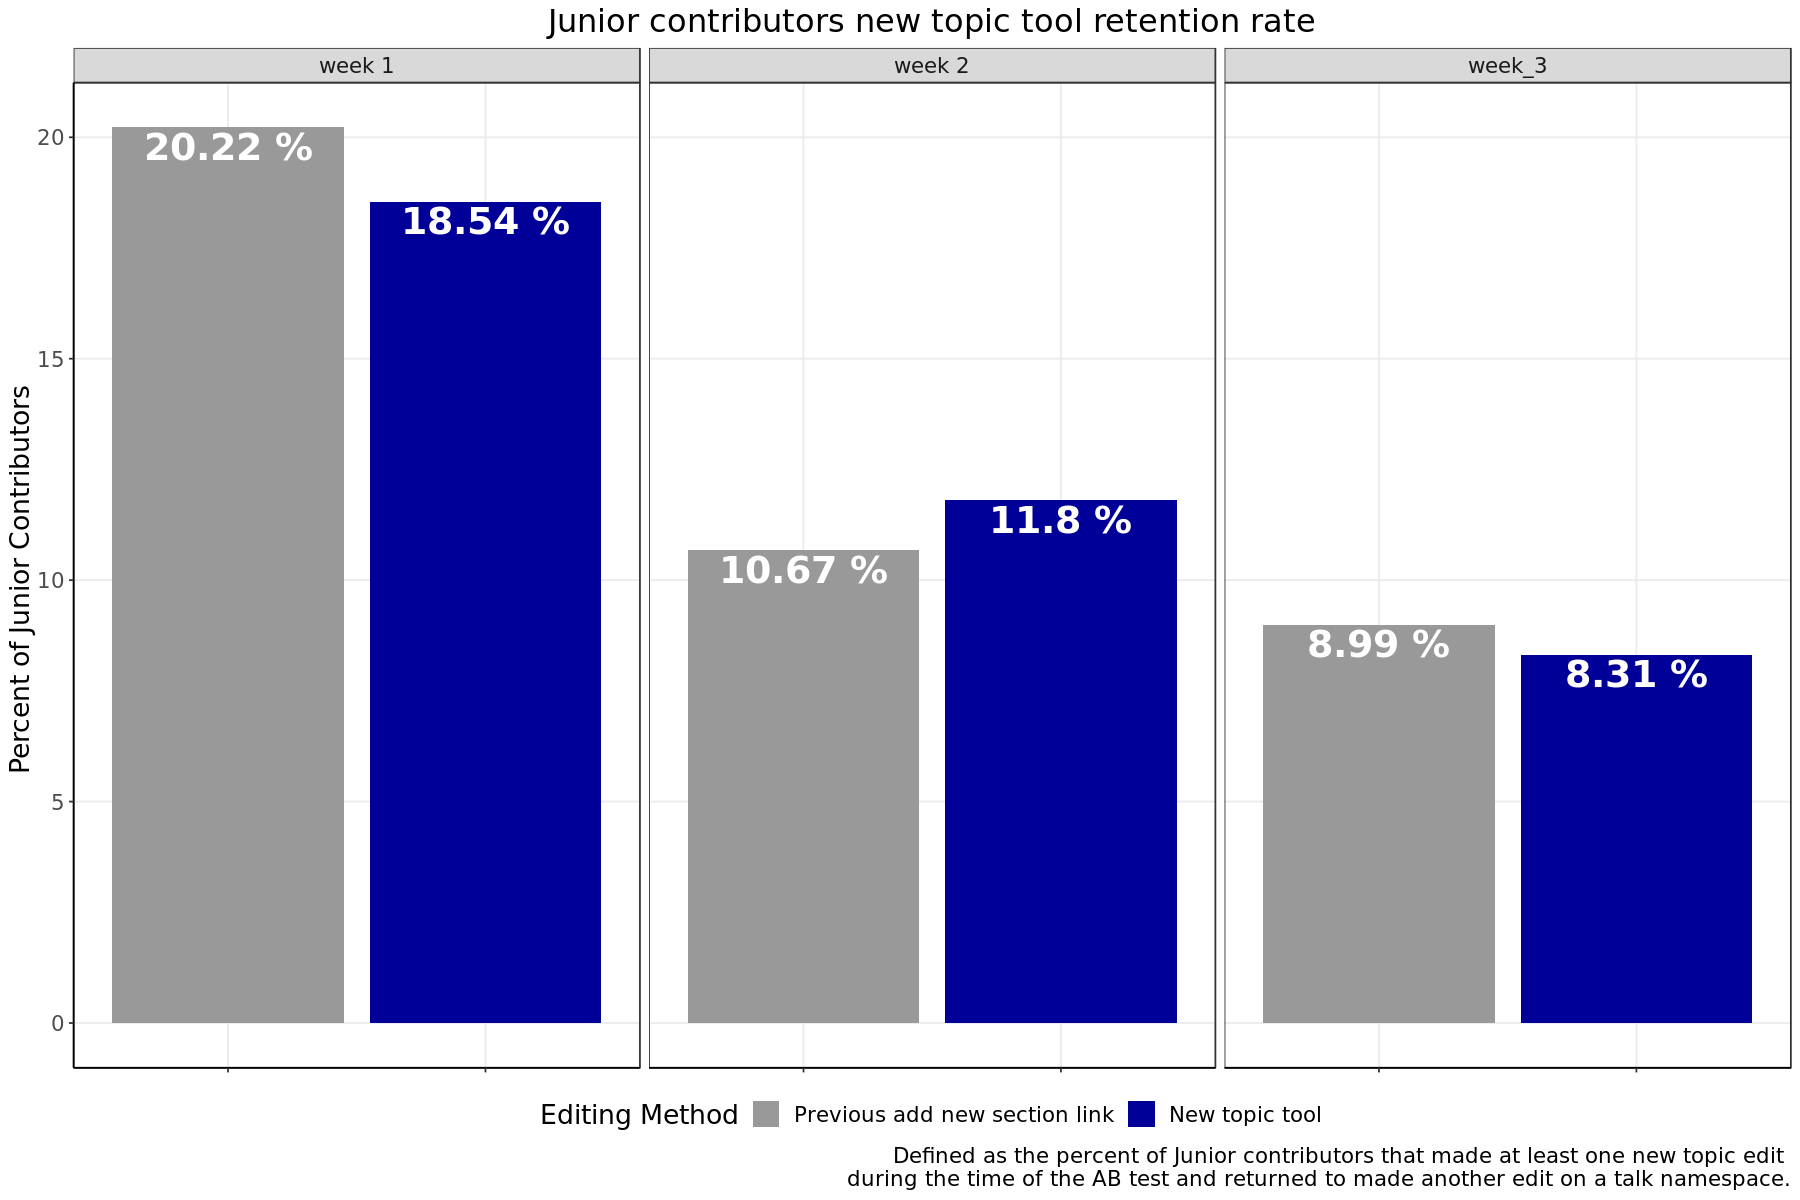

In [98]:
# Plot retention rates 
p <- retention_rates_all %>%
    filter(experience_level == 'Junior Contributor') %>%
    gather("week", "retention_rate", 3:5) %>%
    mutate(week = factor(week,
                         levels = c("first_week_retention_rate", "two_week_retention_rate", "third_week_retention_rate"),
                         labels = c("week 1", "week 2", "week_3")))  %>%
    ggplot(aes(x= section_edit_type, y = retention_rate*100, fill = section_edit_type)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(round(retention_rate*100, 2), "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_wrap(~ week) +
    scale_y_continuous() +
    labs (y = "Percent of Junior Contributors ",
          title = "Junior contributors new topic tool retention rate",
         caption = "Defined as the percent of Junior contributors that made at least one new topic edit \n during the time of the AB test and returned to made another edit on a talk namespace.")  +
    theme_bw() +
   scale_fill_manual(values= c("#999999", "#000099"), name = "Editing Method", labels = c("Previous add new section link", "New topic tool"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p
ggsave("Figures/jc_retention_rate.png", p, width = 16, height = 8, units = "in", dpi = 300)

There is not a lot of variation between the retention rates observed for the existing add new section link and the new topic tool. We see the highest percentage of Junior Contributors return one week after making an edit with either new topic editing type with similar decreases during week 2 and week 3. 

There is a slightly lower percentage of new topic tool users that return 1 week after making an edit and slightly higher percentage that return two weeks after making an edit.

# Steps for future investigation

- Explore other methods to investigate the impact of experience level on the differing completion and revert rates.
- Consider potential impacts of IP blocking, Russia invasion of Ukraine and Growth Experiments while evaluating results.

